In [9]:
import os
import numpy as np
import scipy.io as sio

# Load the data from the specified .mat file
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)
tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']



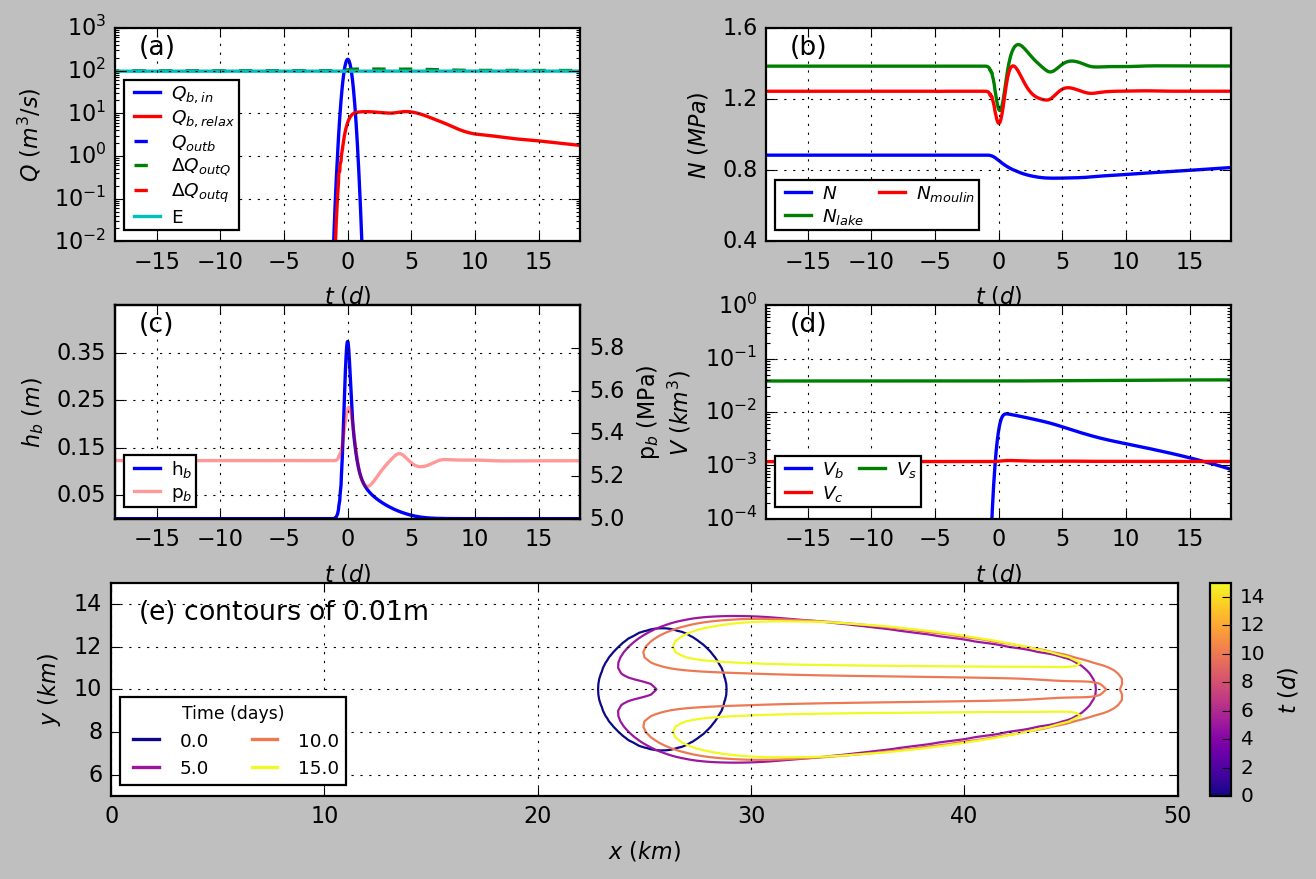

In [ ]:
# This is a draft of the plot showing the evolution of the blister with an efficient subglacial hydrology model
# with moulin input = 100 m3/s, leading to a channel at the center line of the glacier.
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = 0.0
Q_out_q0_interp = 0.0
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3, 365*3+5,365*3+10, 365*3+15])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

# --- Set up figure with GridSpec ----------------------------------------
fig = plt.figure(figsize=(9, 6), constrained_layout=False)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.4, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 10
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# Panel (a) — flux
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax1.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax1.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax1.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax1.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax1.plot(t-td, E,       '-',    linewidth=1.5, label='E')
ax1.set_yscale('log')
ax1.set_xlim(tmin_d-td, tmax_d-td)
ax1.set_xlabel('$t~(d)$')
ax1.set_ylim(1e-2, 1e3)
ax1.set_ylabel(r'$Q~(m^3/s)$')
ax1.legend(loc='lower left',  bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize='small',
           labelspacing=0.2, handletextpad=0.3, borderpad=0.2)
ax1.text(0.05, 0.85, '(a)', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax1.grid()

# Panel (b) — effective pressure
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t-td, N/1e6, '-', linewidth=1.5, label='$N$')
ax2.plot(t-td, pts_N_lake/1e6, '-', linewidth=1.5, label='$N_{lake}$')
ax2.plot(t-td, pts_N_moulin/1e6, '-', linewidth=1.5, label='$N_{moulin}$')
ax2.set_xlim(tmin_d-td, tmax_d-td)
ax2.set_xlabel('$t~(d)$')
ax2.set_yticks(np.arange(0.4, 1.6, 0.4))
ax2.set_ylim(0.4, 1.6)
ax2.set_ylabel('$N~(MPa)$')
ax2.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax2.text(0.05, 0.85, '(b)', transform=ax2.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax2.grid()


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(t-td, pts_hb_lake, 'b-', linewidth=1.5, label='h$_b$')
ax3.set_ylabel('$h_b~(m)$')
ax3.set_yticks(np.arange(0.05, 0.45, 0.1))
ax3.set_ylim(0.0, 0.45)
ax3.set_xlim(tmin_d-td, tmax_d-td)

ax3b = ax3.twinx()
ax3b.plot(t-td, pts_phi_lake/1e6, 'r-', linewidth=1.5, label='p$_b$', alpha=0.4)
ax3b.set_ylabel('p$_b$ (MPa)')
ax3b.set_yticks(np.arange(5.0, 6.0, 0.2))
ax3b.set_ylim(5.0, 6.0)

ax3.set_xlabel('$t~(d)$')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3b.legend(lines1 + lines2, labels1 + labels2, loc='lower left', ncol=1, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax3.text(0.05, 0.85, '(c)', transform=ax3.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax3.grid()

# Panel (d) — V_b, V_c, V_s
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t-td, V_b/1e9, 'b-', linewidth=1.5, label='$V_b$')
ax4.plot(t-td, V_c/1e9, 'r-', linewidth=1.5, label='$V_c$')
ax4.plot(t-td, V_s/1e9, 'g-', linewidth=1.5, label='$V_s$')
ax4.set_xlim(tmin_d-td, tmax_d-td)
ax4.set_xlabel('$t~(d)$')
ax4.set_yscale('log')
ax4.set_ylim(1e-4, 1e0)
ax4.set_ylabel('$V~(km^3)$', fontsize=10)
ax4.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax4.text(0.05, 0.85, '(d)', transform=ax4.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax4.grid()

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=10)

# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False) # Hide original axes

# Get positions of the axes above to align with
pos_left = ax3.get_position()
pos_right = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Define new positions for panel (e) and its colorbar
colorbar_width = 0.015
pad = 0.01
ax5_width = (pos_right.x1 - pos_left.x0) - colorbar_width - pad
ax5_pos = [pos_left.x0, pos_bottom.y0, ax5_width, pos_bottom.height]
cax_pos = [pos_left.x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)
cax = fig.add_axes(cax_pos)

import matplotlib.cm as cm
cmap = plt.cm.plasma
norm = PowerNorm(gamma=1.0, vmin=np.min(vt), vmax=np.max(vt))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    CS = ax5.contour(xx, yy, ps_hb * vhb[i], levels=[0.01], colors=[color_i])

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('$t~(d)$', fontsize=10)
cbar.ax.tick_params(labelsize=9)
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=cmap(norm(v)), linewidth=1.5)
           for v in vt]
labels  = [f"{v:.1f}" for v in vt]
ax5.legend(handles, labels,
           title='Time (days)',
           loc='lower left',
           fontsize='small',
           ncol=2,
           bbox_to_anchor=(0.0, 0.01))

ax5.set_xlim(0, 50)
ax5.set_ylim(5, 15)
ax5.set_xlabel('$x~(km)$')
ax5.set_ylabel('$y~(km)$')

ax5.grid()
pos3 = ax3.get_position()
pos4 = ax4.get_position()
pos5 = ax5.get_position()

# Set the left and right boundaries of ax5 to match ax3 and ax4
ax5.set_position([pos3.x0-0.02, pos5.y0, pos4.x1 - pos3.x0, pos5.height])
ax5.set_aspect('equal', adjustable='box')
ax5.text(0.025, 0.8, '(e) contours of $0.01$m', transform=ax5.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
plt.show()

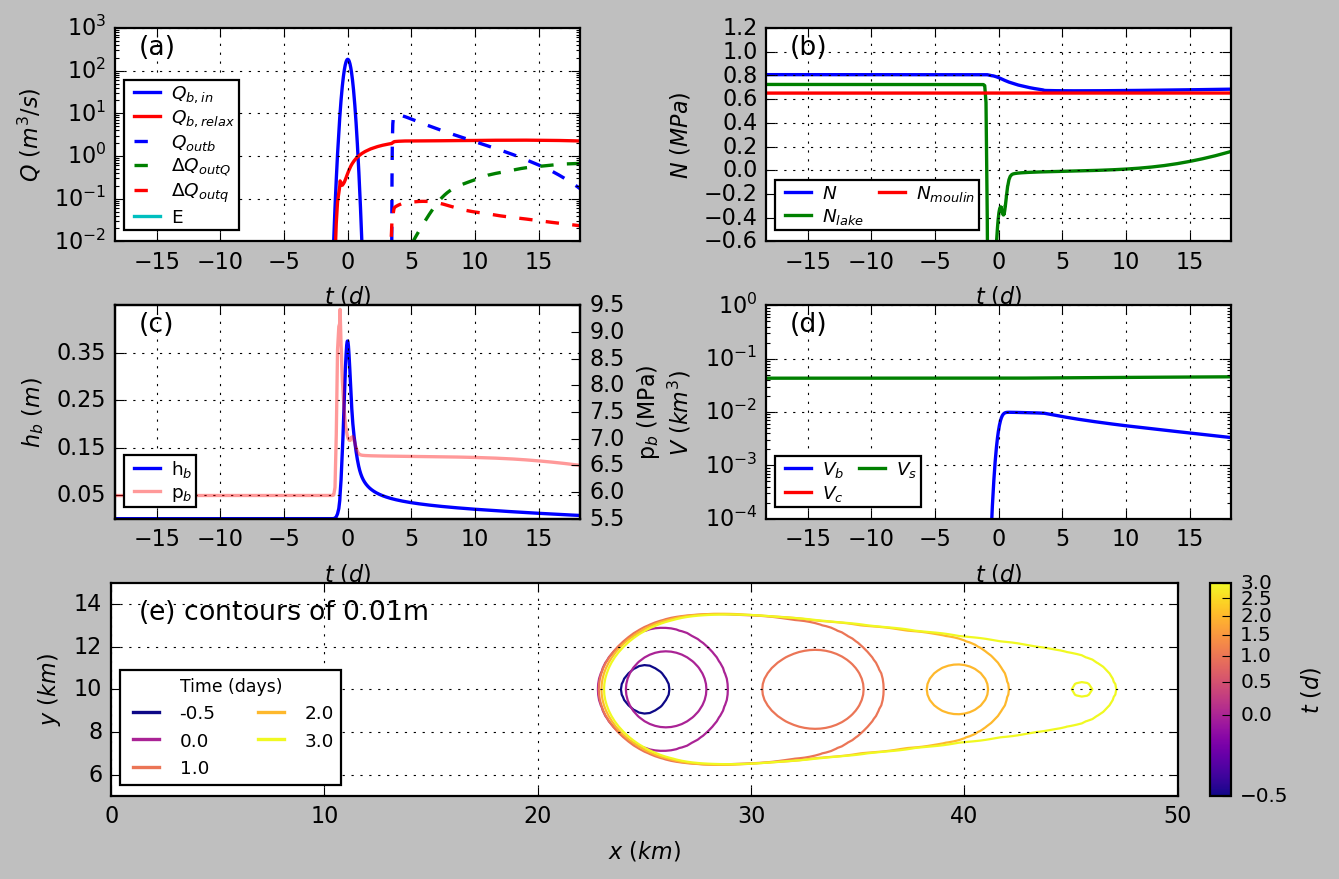

In [ ]:
# This is a draft of the plot showing the evolution of the blister with an inefficient subglacial hydrology model
# with moulin input = 0 m3/s, with almost no channel and sheet flow at the center line of the glacier.
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
casename = 'n2d_0m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = 0.0
Q_out_q0_interp = 0.0
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3-0.5, 365*3, 365*3+1, 365*3+2, 365*3+3])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

# --- Set up figure with GridSpec ----------------------------------------
fig = plt.figure(figsize=(9, 6), constrained_layout=False)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.4, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 10
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# Panel (a) — flux
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax1.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax1.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax1.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax1.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax1.plot(t-td, E,       '-',    linewidth=1.5, label='E')
ax1.set_yscale('log')
ax1.set_xlim(tmin_d-td, tmax_d-td)
ax1.set_xlabel('$t~(d)$')
ax1.set_ylim(1e-2, 1e3)
ax1.set_ylabel(r'$Q~(m^3/s)$')
ax1.legend(loc='lower left', bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize='small',
           labelspacing=0.2, handletextpad=0.3, borderpad=0.2)
ax1.text(0.05, 0.85, '(a)', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax1.grid()

# Panel (b) — effective pressure
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t-td, N/1e6, '-', linewidth=1.5, label='$N$')
ax2.plot(t-td, pts_N_lake/1e6, '-', linewidth=1.5, label='$N_{lake}$')
ax2.plot(t-td, pts_N_moulin/1e6, '-', linewidth=1.5, label='$N_{moulin}$')
ax2.set_xlim(tmin_d-td, tmax_d-td)
ax2.set_xlabel('$t~(d)$')
# ax2.set_yticks(np.arange(0.4, 1.6, 0.4))
ax2.set_ylim(-0.6, 1.2)
ax2.set_ylabel('$N~(MPa)$')
ax2.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax2.text(0.05, 0.85, '(b)', transform=ax2.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax2.grid()


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(t-td, pts_hb_lake, 'b-', linewidth=1.5, label='h$_b$')
ax3.set_ylabel('$h_b~(m)$')
ax3.set_yticks(np.arange(0.05, 0.45, 0.1))
ax3.set_ylim(0.0, 0.45)
ax3.set_xlim(tmin_d-td, tmax_d-td)

ax3b = ax3.twinx()
ax3b.plot(t-td, pts_phi_lake/1e6, 'r-', linewidth=1.5, label='p$_b$', alpha=0.4)
ax3b.set_ylabel('p$_b$ (MPa)')
# ax3b.set_yticks(np.arange(5.0, 6.0, 0.2))
# ax3b.set_ylim(5.0, 6.0)

ax3.set_xlabel('$t~(d)$')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3b.legend(lines1 + lines2, labels1 + labels2, loc='lower left', ncol=1, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax3.text(0.05, 0.85, '(c)', transform=ax3.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax3.grid()

# Panel (d) — V_b, V_c, V_s
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t-td, V_b/1e9, 'b-', linewidth=1.5, label='$V_b$')
ax4.plot(t-td, V_c/1e9, 'r-', linewidth=1.5, label='$V_c$')
ax4.plot(t-td, V_s/1e9, 'g-', linewidth=1.5, label='$V_s$')
ax4.set_xlim(tmin_d-td, tmax_d-td)
ax4.set_xlabel('$t~(d)$')
ax4.set_yscale('log')
ax4.set_ylim(1e-4, 1e0)
ax4.set_ylabel('$V~(km^3)$', fontsize=10)
ax4.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax4.text(0.05, 0.85, '(d)', transform=ax4.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax4.grid()

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=10)

# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False) # Hide original axes

# Get positions of the axes above to align with
pos_left = ax3.get_position()
pos_right = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Define new positions for panel (e) and its colorbar
colorbar_width = 0.015
pad = 0.01
ax5_width = (pos_right.x1 - pos_left.x0) - colorbar_width - pad
ax5_pos = [pos_left.x0, pos_bottom.y0, ax5_width, pos_bottom.height]
cax_pos = [pos_left.x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)
cax = fig.add_axes(cax_pos)

import matplotlib.cm as cm
cmap = plt.cm.plasma
norm = PowerNorm(gamma=0.5, vmin=np.min(vt), vmax=np.max(vt))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    CS = ax5.contour(xx, yy, ps_hb * vhb[i], levels=[0.01, 0.2], colors=[color_i])

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('$t~(d)$', fontsize=10)
cbar.ax.tick_params(labelsize=9)
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=cmap(norm(v)), linewidth=1.5)
           for v in vt]
labels  = [f"{v:.1f}" for v in vt]
ax5.legend(handles, labels,
           title='Time (days)',
           loc='lower left',
           fontsize='small',
           ncol=2,
           bbox_to_anchor=(0.0, 0.01))

ax5.set_xlim(0, 50)
ax5.set_ylim(5, 15)
ax5.set_xlabel('$x~(km)$')
ax5.set_ylabel('$y~(km)$')

ax5.grid()
pos3 = ax3.get_position()
pos4 = ax4.get_position()
pos5 = ax5.get_position()

# Set the left and right boundaries of ax5 to match ax3 and ax4
ax5.set_position([pos3.x0-0.02, pos5.y0, pos4.x1 - pos3.x0, pos5.height])
ax5.set_aspect('equal', adjustable='box')
ax5.text(0.025, 0.8, '(e) contours of $0.01$m', transform=ax5.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
plt.show()

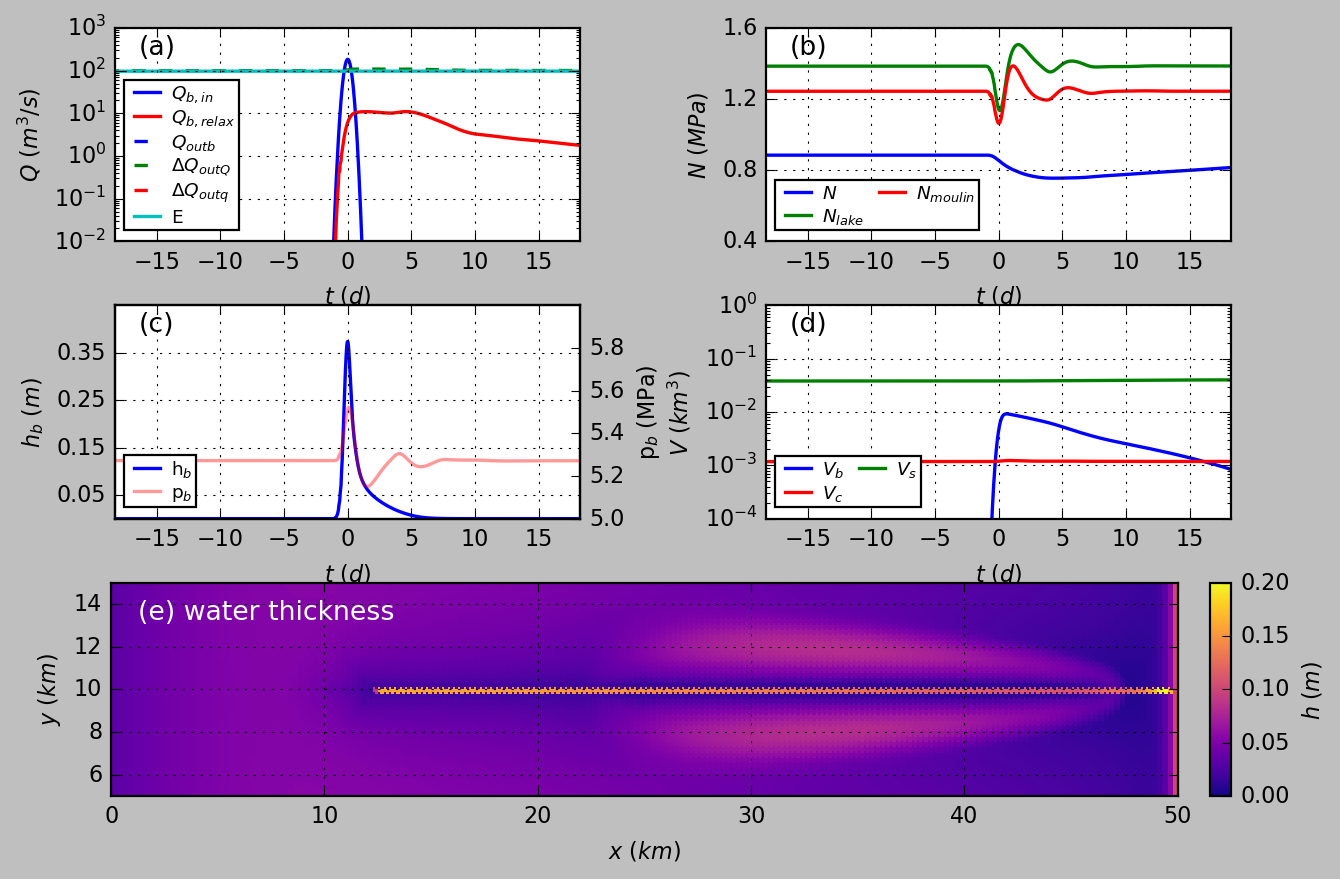

In [590]:
# This is a draft of the plot showing the evolution of the blister with an efficient subglacial hydrology model
# with moulin input = 100 m3/s, leading to a channel at the center line of the glacier.
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

pp_c8 = np.float64(pp['c8'])
# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = 0.0
Q_out_q0_interp = 0.0
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())
eI = int(gg['eI'].item())
eJ = int(gg['eJ'].item())
cI = int(gg['cI'].item())
cJ = int(gg['cJ'].item())

nmeanx = gg['nmeanx'].item()
nmeany = gg['nmeany'].item()
nmeans = gg['nmeans'].item()
nmeanr = gg['nmeanr'].item()
ein = gg['ein'].item()
fin = gg['fin'].item()
cin = gg['cin'].item()
Dx = np.float64(gg['Dx'].item())
Dy = np.float64(gg['Dy'].item())
Ds = np.float64(gg['Ds'].item())
Dr = np.float64(gg['Dr'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3, 365*3+1,365*3+5, 365*3+10])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vhc = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    pb_val   = np.float64(vv['pb'].item())

    Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
    Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
    Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
    Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
    vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
    vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
    vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
    vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

# --- Set up figure with GridSpec ----------------------------------------
fig = plt.figure(figsize=(9, 6), constrained_layout=False)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.4, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 10
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# Panel (a) — flux
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax1.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax1.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax1.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax1.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax1.plot(t-td, E,       '-',    linewidth=1.5, label='E')
ax1.set_yscale('log')
ax1.set_xlim(tmin_d-td, tmax_d-td)
ax1.set_xlabel('$t~(d)$')
ax1.set_ylim(1e-2, 1e3)
ax1.set_ylabel(r'$Q~(m^3/s)$')
ax1.legend(loc='lower left',  bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize='small',
           labelspacing=0.2, handletextpad=0.3, borderpad=0.2)
ax1.text(0.05, 0.85, '(a)', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax1.grid()

# Panel (b) — effective pressure
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t-td, N/1e6, '-', linewidth=1.5, label='$N$')
ax2.plot(t-td, pts_N_lake/1e6, '-', linewidth=1.5, label='$N_{lake}$')
ax2.plot(t-td, pts_N_moulin/1e6, '-', linewidth=1.5, label='$N_{moulin}$')
ax2.set_xlim(tmin_d-td, tmax_d-td)
ax2.set_xlabel('$t~(d)$')
ax2.set_yticks(np.arange(0.4, 1.6, 0.4))
ax2.set_ylim(0.4, 1.6)
ax2.set_ylabel('$N~(MPa)$')
ax2.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax2.text(0.05, 0.85, '(b)', transform=ax2.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax2.grid()


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(t-td, pts_hb_lake, 'b-', linewidth=1.5, label='h$_b$')
ax3.set_ylabel('$h_b~(m)$')
ax3.set_yticks(np.arange(0.05, 0.45, 0.1))
ax3.set_ylim(0.0, 0.45)
ax3.set_xlim(tmin_d-td, tmax_d-td)

ax3b = ax3.twinx()
ax3b.plot(t-td, pts_phi_lake/1e6, 'r-', linewidth=1.5, label='p$_b$', alpha=0.4)
ax3b.set_ylabel('p$_b$ (MPa)')
ax3b.set_yticks(np.arange(5.0, 6.0, 0.2))
ax3b.set_ylim(5.0, 6.0)

ax3.set_xlabel('$t~(d)$')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3b.legend(lines1 + lines2, labels1 + labels2, loc='lower left', ncol=1, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax3.text(0.05, 0.85, '(c)', transform=ax3.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax3.grid()

# Panel (d) — V_b, V_c, V_s
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t-td, V_b/1e9, 'b-', linewidth=1.5, label='$V_b$')
ax4.plot(t-td, V_c/1e9, 'r-', linewidth=1.5, label='$V_c$')
ax4.plot(t-td, V_s/1e9, 'g-', linewidth=1.5, label='$V_s$')
ax4.set_xlim(tmin_d-td, tmax_d-td)
ax4.set_xlabel('$t~(d)$')
ax4.set_yscale('log')
ax4.set_ylim(1e-4, 1e0)
ax4.set_ylabel('$V~(km^3)$', fontsize=10)
ax4.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax4.text(0.05, 0.85, '(d)', transform=ax4.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax4.grid()

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=10)

# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False) # Hide original axes

# Get positions of the axes above to align with
pos_left = ax3.get_position()
pos_right = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Define new positions for panel (e) and its colorbar
colorbar_width = 0.015
pad = 0.01
ax5_width = (pos_right.x1 - pos_left.x0) - colorbar_width - pad
ax5_pos = [pos_left.x0, pos_bottom.y0, ax5_width, pos_bottom.height]
cax_pos = [pos_left.x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)
cax = fig.add_axes(cax_pos)

import matplotlib.cm as cm
cmap = plt.cm.plasma
norm = PowerNorm(gamma=1.0, vmin=0, vmax=0.2)

for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    pc = ax5.pcolormesh(xx, yy,
                        ps_hb * vhb[i] + ps_h * vhs[i] + ps_h * vhc[i],
                        cmap=cmap, norm=norm, shading='auto')
    pc.set_edgecolor('face')  # Avoid grid lines

# set up colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)


ax5.set_xlim(0, 50)
ax5.set_ylim(5, 15)
ax5.set_xlabel('$x~(km)$')
ax5.set_ylabel('$y~(km)$')

ax5.grid()
pos3 = ax3.get_position()
pos4 = ax4.get_position()
pos5 = ax5.get_position()

# Set the left and right boundaries of ax5 to match ax3 and ax4
ax5.set_position([pos3.x0-0.02, pos5.y0, pos4.x1 - pos3.x0, pos5.height])
ax5.set_aspect('equal', adjustable='box')
ax5.text(0.025, 0.8, '(e) water thickness', transform=ax5.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False, color='white')
plt.show()

In [56]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec

# Plotting options
plot_difference = False

# --- Import data ---------------------------------------------------------
# backgroud field with no lake input
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V0e7_test'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)
tt = raw['tt']
ps = raw['ps']
ps_t   = np.float64(ps['t'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])
tt_t      = np.float64(tt['t'])
t0 = (ps_t / (24*60*60)) * tt_t        # days
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
Q_out_b0 = ps_Q0 * tt_Q_outb
Q_out_Q0 = ps_Q  * tt_Q_outQ
Q_out_q0 = ps_Q  * tt_Q_outq

casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

pp_c8 = np.float64(pp['c8'])
# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = np.float64(np.interp(t, t0, Q_out_Q0))
Q_out_q0_interp = np.float64(np.interp(t, t0, Q_out_q0))

Q_out_b = ps_Q0 * tt_Q_outb
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())
eI = int(gg['eI'].item())
eJ = int(gg['eJ'].item())
cI = int(gg['cI'].item())
cJ = int(gg['cJ'].item())

nmeanx = gg['nmeanx'].item()
nmeany = gg['nmeany'].item()
nmeans = gg['nmeans'].item()
nmeanr = gg['nmeanr'].item()
ein = gg['ein'].item()
fin = gg['fin'].item()
cin = gg['cin'].item()
Dx = np.float64(gg['Dx'].item())
Dy = np.float64(gg['Dy'].item())
Ds = np.float64(gg['Ds'].item())
Dr = np.float64(gg['Dr'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3-5, 365*3, 365*3+2, 365*3+5])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vhc = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    pb_val   = np.float64(vv['pb'].item())

    Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
    Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
    Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
    Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
    vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
    vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
    vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
    vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

fig = plt.figure(figsize=(9, 6), dpi=600)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

xa = 10 
xb = 50
ya = 0
yb = 20
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0, 0])
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=1e-2, vmax=1.0e0)
cmap = plt.cm.Blues
pc = ax1.pcolormesh(xx, yy,
                    ps_hb * vhb[0] + ps_h * vhs[0] + ps_h * vhc[0],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='gouraud')
pc.set_edgecolor('face')
# Plot contour lines for the blister alone
# contour_lines = ax1.contour(xx, yy, ps_hb * vhb[0], levels=[0.01, 0.2], colors='w', linewidths=0.5, linestyles='-')
# ax1.clabel(
#     contour_lines,
#     inline=True,
#     fontsize=6,
#     fmt='%1.2f',
#     inline_spacing=2,
#     manual=[(20, 5), (27, 12)],# 手动指定少量标签位置
# )
contour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[0], colors='w', linewidths=0.5, linestyles='-')
# ax1.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# plot the moulin location
ax1.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax1.text(0.025, 0.9, '(a) $t=$ '+ f'${vt[0]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')
ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
# ax1.set_xlabel('$x~(km)$')
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal')
ax1.grid()

# ================= Panel (b): blister at time b ================
ax2 = fig.add_subplot(gs[0, 1])
cmap = plt.cm.Blues
# Create a color mesh for the total water thickness
pc = ax2.pcolormesh(xx, yy,
                    ps_hb * (vhb[1]-plot_difference*vhb[0]) + ps_h * (vhs[1]-plot_difference*vhs[0]) + ps_h * (vhc[1]-plot_difference*vhc[0]), 
                    cmap=cmap, norm=norm, shading='gouraud')
pc.set_edgecolor('face')
cbar = fig.colorbar(pc, ax=ax2, orientation='vertical', shrink=0.95, pad=0.04)
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
# contour_lines = ax2.contour(xx, yy, ps_hb * vhb[1], levels=[0.01, 0.2], colors='w', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax2.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='w', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax2.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax2.text(0.025, 0.9, '(b) $t=$ '+ f'${vt[1]:.1f}$ d', transform=ax2.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')
ax2.set_xlim(xa, xb)
ax2.set_ylim(ya, yb)
# ax2.set_xlabel('$x~(km)$')
# ax2.set_ylabel('$y~(km)$')
ax2.set_aspect('equal')
ax2.grid()

# ================= Panel (c): blister at time c ================
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Blues
pc = ax3.pcolormesh(xx, yy,
                    ps_hb * (vhb[2]-plot_difference*vhb[0]) + ps_h * (vhs[2]-plot_difference*vhs[0]) + ps_h * (vhc[2]-plot_difference*vhc[0]),
                    cmap=cmap, norm=norm, shading='gouraud')
pc.set_edgecolor('face')    
# Plot contour lines for the blister alone
# contour_lines = ax3.contour(xx, yy, ps_hb * vhb[2], levels=[0.01, 0.05], colors='w', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax3.contour(xx, yy, ps_phi/1e6*vphi1[2], colors='w', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax3.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax3.text(0.025, 0.9, '(c) $t=$ '+ f'${vt[2]:.1f}$ d', transform=ax3.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')

ax3.set_xlim(xa, xb)
ax3.set_ylim(ya, yb)
ax3.set_xlabel('$x~(km)$')
ax3.set_ylabel('$y~(km)$')
ax3.set_aspect('equal')
ax3.grid()

# ================= Panel (d): blister at time d ================
ax4 = fig.add_subplot(gs[1, 1])
cmap = plt.cm.Blues
# Create a color mesh for the total water thickness
pc = ax4.pcolormesh(xx, yy,
                    ps_hb * (vhb[3]-plot_difference*vhb[0]) + ps_h * (vhs[3]-plot_difference*vhs[0]) + ps_h * (vhc[3]-plot_difference*vhc[0]),  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='gouraud')
pc.set_edgecolor('face')
cbar = fig.colorbar(pc, ax=ax4, orientation='vertical', shrink=0.95, pad=0.04)
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
# contour_lines = ax4.contour(xx, yy, ps_hb * vhb[3], levels=[0.01, 0.1], colors='w', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax4.contour(xx, yy, ps_phi/1e6*vphi1[3], colors='w', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax4.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax4.text(0.025, 0.9, '(d) $t=$ '+ f'${vt[3]:.1f}$ d', transform=ax4.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')

ax4.set_xlim(xa, xb)
ax4.set_ylim(ya, yb)
ax4.set_xlabel('$x~(km)$')
# ax4.set_ylabel('$y~(km)$')
ax4.set_aspect('equal')
ax4.grid()

# ============== Panel (e): Flux (last row: spanning both columns) ==============
# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_left   = ax3.get_position()
pos_right  = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Compute full available width
full_width = pos_right.x1 - pos_left.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax5_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
ax5_pos = [ax5_x0, pos_bottom.y0, ax5_width+0.02, pos_bottom.height]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax5_x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)

ax5.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax5.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax5.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax5.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax5.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax5.plot(t-td, E,       '-',    linewidth=1.5, label='E')

# vertical lines for time points in (a), (b), (c), (d)
labels = ['(a)', '(b)', '(c)', '(d)']
for i,t_val in enumerate(vt):
    ax5.axvline(t_val, ymin=1e-6, ymax=1e5, color='k', linestyle='--', linewidth=1.0, alpha=1.0, dashes=(2, 2))
    ax5.text(t_val, 1e3, labels[i], ha='center', va='bottom', fontsize=8, color='k')

ax5.set_yscale('log')
ax5.set_xlim(tmin_d-td, tmax_d-td)
ax5.set_xlabel('$t~(d)$')
ax5.set_ylim(1e-2, 1e3)
ax5.set_ylabel(r'$Q~(m^3/s)$')
ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False)
ax5.legend(loc='lower left',  bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize=8, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax5.grid(alpha=0.5)

# save *before* plt.show()
# fig.savefig(
#     'Fig3_summertime.png',
#     dpi=600,
#     transparent=False,
#     bbox_inches='tight',
#     pad_inches=0
# )
plt.show()

In [2]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
# --- Import data ---------------------------------------------------------
# background field with no lake input
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V0e7_test'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)
tt = raw['tt']
ps = raw['ps']
ps_t   = np.float64(ps['t'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])
tt_t      = np.float64(tt['t'])
t0 = (ps_t / (24*60*60)) * tt_t        # days
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
Q_out_b0 = ps_Q0 * tt_Q_outb
Q_out_Q0 = ps_Q  * tt_Q_outQ
Q_out_q0 = ps_Q  * tt_Q_outq

casename = 'n2d_0m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

pp_c8 = np.float64(pp['c8'])
# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = np.float64(np.interp(t, t0, Q_out_Q0))
Q_out_q0_interp = np.float64(np.interp(t, t0, Q_out_q0))

Q_out_b = ps_Q0 * tt_Q_outb
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())
eI = int(gg['eI'].item())
eJ = int(gg['eJ'].item())
cI = int(gg['cI'].item())
cJ = int(gg['cJ'].item())

nmeanx = gg['nmeanx'].item()
nmeany = gg['nmeany'].item()
nmeans = gg['nmeans'].item()
nmeanr = gg['nmeanr'].item()
ein = gg['ein'].item()
fin = gg['fin'].item()
cin = gg['cin'].item()
Dx = np.float64(gg['Dx'].item())
Dy = np.float64(gg['Dy'].item())
Ds = np.float64(gg['Ds'].item())
Dr = np.float64(gg['Dr'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3, 365*3+1,365*3+5, 365*3+15])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vhc = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    pb_val   = np.float64(vv['pb'].item())

    Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
    Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
    Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
    Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
    vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
    vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
    vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
    vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

fig = plt.figure(figsize=(9, 6), dpi=600)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

xa = 10 
xb = 50
ya = 0
yb = 20
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0, 0])
norm = LogNorm(vmin=1e-3, vmax=5e-1)
cmap = plt.cm.Blues
pc = ax1.pcolormesh(xx, yy,
                    ps_hb * vhb[0] + ps_h * vhs[0] + ps_h * vhc[0],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')
# Plot contour lines for the blister alone
# contour_lines = ax1.contour(xx, yy, ps_hb * vhb[0], levels=[0.01, 0.2], colors='w', linewidths=0.5, linestyles='-')
# ax1.clabel(
#     contour_lines,
#     inline=True,
#     fontsize=6,
#     fmt='%1.2f',
#     inline_spacing=2,
#     manual=[(20, 5), (27, 12)],# 手动指定少量标签位置
# )
contour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[0], colors='w', linewidths=0.5, linestyles='-')
ax1.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# plot the moulin location
ax1.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax1.text(0.025, 0.9, '(a) $t=$ '+ f'${vt[0]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')
ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
# ax1.set_xlabel('$x~(km)$')
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal')
ax1.grid()

# ================= Panel (b): blister at time b ================
ax2 = fig.add_subplot(gs[0, 1])
cmap = plt.cm.Blues
# Create a color mesh for the total water thickness
pc = ax2.pcolormesh(xx, yy,
                    ps_hb * vhb[1] + ps_h * vhs[1] + ps_h * vhc[1],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')
cbar = fig.colorbar(pc, ax=ax2, orientation='vertical', shrink=0.95, pad=0.04)
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
# contour_lines = ax2.contour(xx, yy, ps_hb * vhb[1], levels=[0.01, 0.2], colors='w', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax2.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='w', linewidths=0.5, linestyles='-')
ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax2.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax2.text(0.025, 0.9, '(b) $t=$ '+ f'${vt[1]:.1f}$ d', transform=ax2.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')
ax2.set_xlim(xa, xb)
ax2.set_ylim(ya, yb)
# ax2.set_xlabel('$x~(km)$')
# ax2.set_ylabel('$y~(km)$')
ax2.set_aspect('equal')
ax2.grid()

# ================= Panel (c): blister at time c ================
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Blues
pc = ax3.pcolormesh(xx, yy,
                    ps_hb * vhb[2] + ps_h * vhs[2] + ps_h * vhc[2],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')    
# Plot contour lines for the blister alone
# contour_lines = ax3.contour(xx, yy, ps_hb * vhb[2], levels=[0.01, 0.05], colors='w', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax3.contour(xx, yy, ps_phi/1e6*vphi1[2], colors='w', linewidths=0.5, linestyles='-')
ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax3.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax3.text(0.025, 0.9, '(c) $t=$ '+ f'${vt[2]:.1f}$ d', transform=ax3.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')

ax3.set_xlim(xa, xb)
ax3.set_ylim(ya, yb)
ax3.set_xlabel('$x~(km)$')
ax3.set_ylabel('$y~(km)$')
ax3.set_aspect('equal')
ax3.grid()

# ================= Panel (d): blister at time d ================
ax4 = fig.add_subplot(gs[1, 1])
cmap = plt.cm.Blues
# Create a color mesh for the total water thickness
pc = ax4.pcolormesh(xx, yy,
                    ps_hb * vhb[3] + ps_h * vhs[3] + ps_h * vhc[3],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')
cbar = fig.colorbar(pc, ax=ax4, orientation='vertical', shrink=0.95, pad=0.04)
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
# contour_lines = ax4.contour(xx, yy, ps_hb * vhb[3], levels=[0.01, 0.1], colors='w', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax4.contour(xx, yy, ps_phi/1e6*vphi1[3], colors='w', linewidths=0.5, linestyles='-')
ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax4.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax4.text(0.025, 0.9, '(d) $t=$ '+ f'${vt[3]:.1f}$ d', transform=ax4.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')

ax4.set_xlim(xa, xb)
ax4.set_ylim(ya, yb)
ax4.set_xlabel('$x~(km)$')
# ax4.set_ylabel('$y~(km)$')
ax4.set_aspect('equal')
ax4.grid()

# ============== Panel (e): Flux (last row: spanning both columns) ==============
# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_left   = ax3.get_position()
pos_right  = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Compute full available width
full_width = pos_right.x1 - pos_left.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax5_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
ax5_pos = [ax5_x0, pos_bottom.y0, ax5_width+0.02, pos_bottom.height]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax5_x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)

ax5.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax5.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax5.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax5.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax5.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax5.plot(t-td, E,       '-',    linewidth=1.5, label='E')

# vertical lines for time points in (a), (b), (c), (d)
labels = ['(a)', '(b)', '(c)', '(d)']
for i,t_val in enumerate(vt):
    ax5.axvline(t_val, ymin=1e-6, ymax=1e5, color='k', linestyle='--', linewidth=1.0, alpha=1.0, dashes=(2, 2))
    ax5.text(t_val, 1e3, labels[i], ha='center', va='bottom', fontsize=8, color='k')

ax5.set_yscale('log')
ax5.set_xlim(tmin_d-td, tmax_d-td)
ax5.set_xlabel('$t~(d)$')
ax5.set_ylim(1e-2, 1e3)
ax5.set_ylabel(r'$Q~(m^3/s)$')
ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False)
ax5.legend(loc='lower left',  bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize=8, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax5.grid(alpha=0.5)

# plt.show()
# … all your plotting …
# save *before* plt.show()
fig.savefig(
    'Fig2_wintertime.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)
plt.show()

Loading new data as requested...
Loading data...
Processing files: ['results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0225.mat']


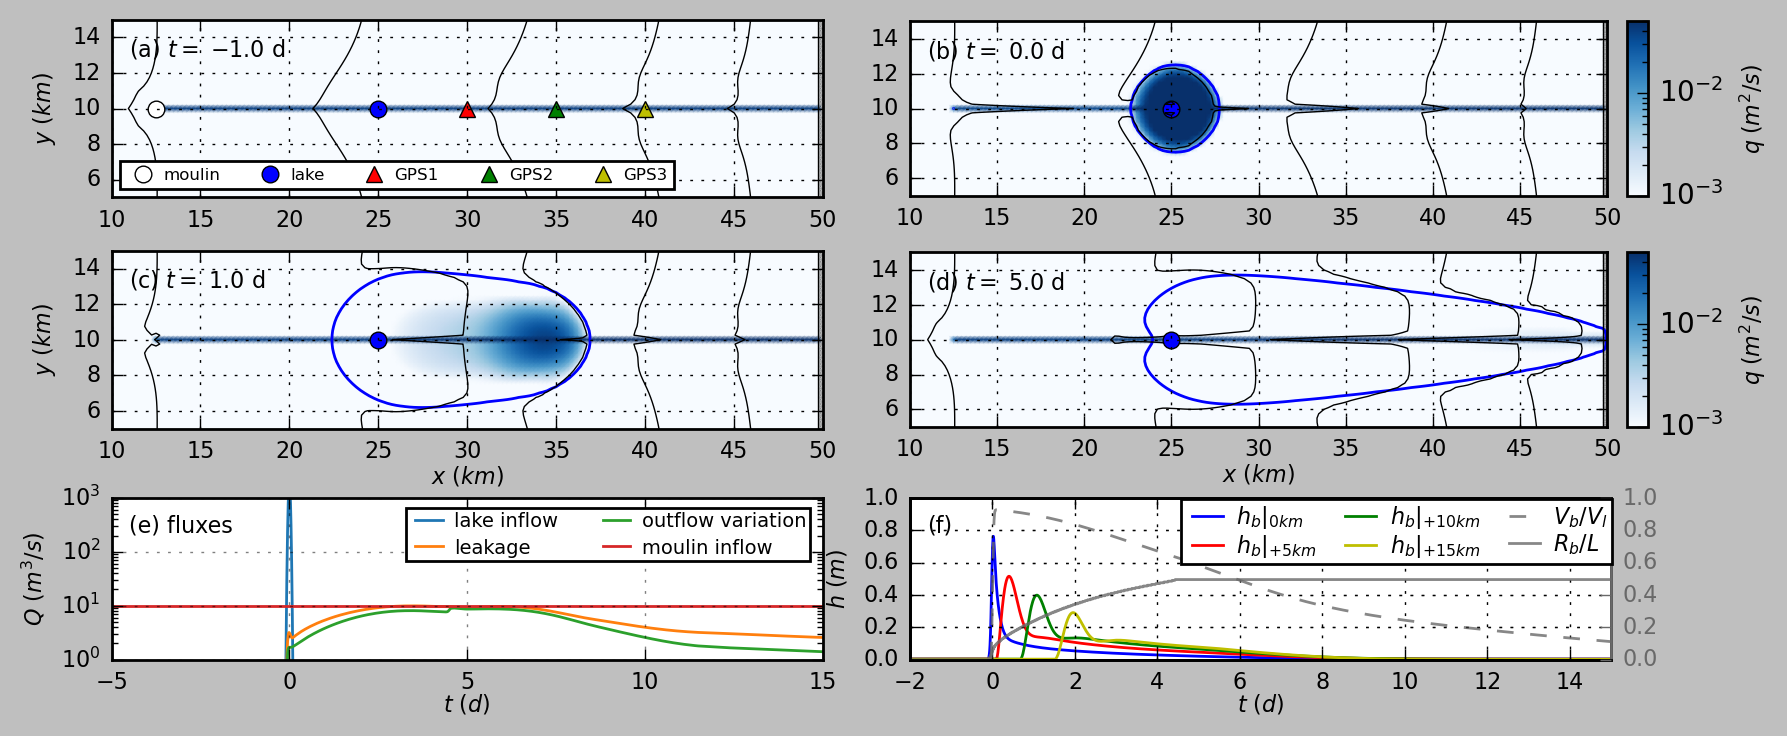

In [9]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Flag to control data import
SKIP_DATA_IMPORT = False
LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data
casename = 'n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage'

# Check if key variables already exist
try:
    # Check if main data variables exist and are not empty
    if 'tt' in locals():
        if LOAD_NEW_DATA:
            print("Loading new data as requested...")
            SKIP_DATA_IMPORT = False
        elif tt is not None:
            print("Data already loaded, skipping import section...")
            SKIP_DATA_IMPORT = True
        else:
            print("Variables exist but are None, reloading data...")
            SKIP_DATA_IMPORT = False
    else:
        print("Variables not found, loading data...")
        SKIP_DATA_IMPORT = False
except NameError:
    print("Variables not defined, loading data...")
    SKIP_DATA_IMPORT = False

# -------------------- Parameters for plotting ---------------------------------------------
from cycler import cycler
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
             "#0072B2","#D55E00","#CC79A7","#000000"]
colors = okabe_ito
colors = plt.get_cmap('tab10').colors  

xa = 10 
xb = 50
ya = 5
yb = 15
plot_hb = False
plot_qs = True
h_min = 0  # min water thickness on the color bar (m)
h_max = 0.1  # max water thickness on the color bar (m)
q_min = 1e-3 # min water flux on the color bar (m^2/s)
q_max = 5e-2 # max water flux on the color bar (m^2/s)
# norm = PowerNorm(gamma=1, vmin=q_min, vmax=q_max)
norm = LogNorm(vmin=q_min, vmax=q_max)

tdrainge_d = 2.0 * 365 + 20
tmin  = tdrainge_d - 5
tmax  = tdrainge_d + 5
tmin_d = tmin 
tmax_d = tmax
tslice = tdrainge_d + np.array([-1, 0, 1, 5])

if (not SKIP_DATA_IMPORT) or (LOAD_NEW_DATA):
    print("Loading data...")
    # ------------------------- Import data -----------------------------------

    mat_path = os.path.join('results', casename, casename + '.mat')
    raw      = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    # 将关键参数转换为数值类型
    ps_t   = np.float64(ps['t'])
    pd_td  = np.float64(pd['td'])
    ps_hb  = np.float64(ps['hb'])
    ps_h   = np.float64(ps['h'])
    ps_x   = np.float64(ps['x'])
    ps_m   = np.float64(ps['m'])
    ps_S   = np.float64(ps['S'])
    ps_phi = np.float64(ps['phi'])
    ps_Q0  = np.float64(ps['Q0'])
    ps_Q   = np.float64(ps['Q'])
    ps_qs  = np.float64(ps['qs'])
    ps_qb  = np.float64(ps['qb'])

    pp_c8 = np.float64(pp['c8'])
    # 同样将 tt 中的数据转换为数值类型
    tt_t      = np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])

    # --- Compute time vectors -----------------------------------------------
    t = (ps_t / (24*60*60)) * tt_t        # days

    # --- Build derived quantities -------------------------------------------
    Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
    Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_Q = ps_Q  * tt_Q_outQ
    Q_out_q = ps_Q  * tt_Q_outq
    E       = ps_m * ps_x**2 * tt_E

    pts_ni = np.int64(oo['pts_ni'].item())
    phi_0 = ps_phi * np.float64(aa['phi_0'].item())
    pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
    pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
    pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
    pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
    pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])
    pts_hc_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hc']])
    pts_hs_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hs']])

    # gps elevations
    #     14 15 16 17    18   19
    #.    8  9  10 11    12   13
    #.    2  3  4   5     6   7
    #.  -1km 0 5km 10km 15km 20km
    pts_hb_gps1 = ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hb']])
    pts_hb_gps2 = ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hb']])
    pts_hb_gps3 = ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hb']])
    pts_hb_gps4 = ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hb']])

    pts_hc_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hc']])
    pts_hc_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hc']])
    pts_hc_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hc']])
    pts_hc_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hc']])

    pts_hs_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hs']])
    pts_hs_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hs']])
    pts_hs_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hs']])
    pts_hs_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hs']])

    N = ps_phi * np.float64(tt['N'])  # MPa
    pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
    pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    # 对空间变量进行转换
    xx = ps_x/1e3 * np.float64(gg['nx'].item())
    yy = ps_x/1e3 * np.float64(gg['ny'].item())
    nI = int(gg['nI'].item())
    nJ = int(gg['nJ'].item())
    eI = int(gg['eI'].item())
    eJ = int(gg['eJ'].item())
    cI = int(gg['cI'].item())
    cJ = int(gg['cJ'].item())

    nmeanx = gg['nmeanx'].item()
    nmeany = gg['nmeany'].item()
    nmeans = gg['nmeans'].item()
    nmeanr = gg['nmeanr'].item()
    ein = gg['ein'].item()
    fin = gg['fin'].item()
    cin = gg['cin'].item()
    Dx = np.float64(gg['Dx'].item())
    Dy = np.float64(gg['Dy'].item())
    Ds = np.float64(gg['Ds'].item())
    Dr = np.float64(gg['Dr'].item())

    # --- get spatial pattern at different times -----------------------------
    tspan = ps_t/pd_td*oo['t_span']
    nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

    # run matlab script to extend the field for times
    filenames = [os.path.join('results', casename, f"{num:04d}.mat") for num in nums]
    print(f"Processing files: {filenames}")
    # save the filenames to a text file
    # Save filenames and casename to a .mat file for MATLAB to load
    filenames_array = np.array(filenames, dtype=object)
    sio.savemat('extend_field.mat', {
        'filenames': filenames_array,
        'casename': casename
    })
    # Use MATLAB’s -batch option to run the script and auto‐exit when done
    import subprocess
    matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
    subprocess.run([
        matlab_path,
        "-nodisplay",
        "-nosplash",
        "-nodesktop",
        "-batch",
        "nevis_nodedischarge_python"
    ], check=True)

    vhb = []
    vphi1 = []
    vhs = []
    vhc = []
    vt = []
    vqs = []
    vqe = []
    vqQ = []
    vqb = []

    for i in range(len(nums)):
        con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
        raw_con = sio.loadmat(con_path, squeeze_me=True)
        vv = raw_con['vv']
        vv2 = raw_con['vv2']

        # geometry values
        phi1_val = np.float64(vv['phi'].item())
        hb_val   = np.float64(vv['hb'].item())
        hs_val   = np.float64(vv['hs'].item())
        pb_val   = np.float64(vv['pb'].item())

        Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
        Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
        Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
        Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

        vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
        vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
        vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
        vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
        vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
        vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
        vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
        vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
        vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
        vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))

        # flux values
        qs_val = np.float64(vv2['qs'].item())
        qe_val = np.float64(vv2['qe'].item())
        qQ_val = np.float64(vv2['qQ'].item())
        qb_val = np.float64(vv2['qb'].item())
        vqs.append(np.array(np.reshape(qs_val, (nI, nJ), order='F'), dtype=np.float64))
        vqe.append(np.array(np.reshape(qe_val, (nI, nJ), order='F'), dtype=np.float64))
        vqQ.append(np.array(np.reshape(qQ_val, (nI, nJ), order='F'), dtype=np.float64))
        vqb.append(np.array(np.reshape(qb_val, (nI, nJ), order='F'), dtype=np.float64))
    vt = np.array(vt, dtype=np.float64)-tdrainge_d

# ================= Plotting setup ======================================
fig = plt.figure(figsize=(10, 4), dpi=100)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.style.use('classic')
plt.rc('axes', prop_cycle=cycler('color', colors))
plt.rcParams["figure.dpi"] = 600
# plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0, 0])
from matplotlib.colors import LogNorm

cmap = plt.cm.Blues
if plot_hb:
    pc = ax1.pcolormesh(xx, yy,
                        ps_hb * vhb[0] + ps_h * vhs[0] + ps_h * vhc[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    # norm = LogNorm(vmin=q_min, vmax=q_max)
    pc = ax1.pcolormesh(xx, yy,
                        ps_qs * vqs[0] + ps_qb * vqb[0] + ps_qs * vqQ[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax1.contour(xx, yy, ps_hb * vhb[0], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax1.clabel(
#     contour_lines,
#     inline=True,
#     fontsize=6,
#     fmt='%1.2f',
#     inline_spacing=2,
#     manual=[(20, 5), (27, 12)],# 手动指定少量标签位置
# )
contour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[0], colors='k', linewidths=0.5, linestyles='-')
# ax1.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# plot the moulin location
ax1.plot(12.5, 10, 'wo', markersize=6, label='moulin')
ax1.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax1.plot(30.0, 10, 'r^', markersize=6, label='GPS1')
ax1.plot(35.0, 10, 'g^', markersize=6, label='GPS2')
ax1.plot(40.0, 10, 'y^', markersize=6, label='GPS3')
# ax1.plot(45.0, 10, 'yo', markersize=6, label='GPS4')

ax1.text(0.025, 0.9, '(a) $t=$ '+ f'${vt[0]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax1.legend(loc='lower left', fontsize=6, frameon=True, handletextpad=0.2, ncol=5, labelspacing=0.2, numpoints=1)
# ax1.legend(loc='upper left', fontsize=6, frameon=False, handletext

ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
# ax1.set_xlabel('$x~(km)$')
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal')
ax1.grid()

# ================= Panel (b): blister at time b ================
ax2 = fig.add_subplot(gs[0, 1])
cmap = plt.cm.Blues
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax2.pcolormesh(xx, yy,
                        ps_hb * vhb[1] + ps_h * vhs[1] + ps_h * vhc[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax2.pcolormesh(xx, yy,
                        ps_qs * vqs[1] + ps_qb * vqb[1] + ps_qs * vqQ[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

ax2.plot(25.0, 10, 'bo', markersize=6, label='lake')
cbar = fig.colorbar(pc, cax=cax2, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
contour_lines = ax2.contour(xx, yy, ps_hb * vhb[1], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax2.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='k', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax2.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax2.text(0.025, 0.9, '(b) $t=$ '+ f'${vt[1]:.1f}$ d', transform=ax2.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax2.set_xlim(xa, xb)
ax2.set_ylim(ya, yb)
# ax2.set_xlabel('$x~(km)$')
# ax2.set_ylabel('$y~(km)$')
ax2.set_aspect('equal')
ax2.grid()

# ================= Panel (c): blister at time c ================
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Blues
if plot_hb:
    pc = ax3.pcolormesh(xx, yy,
                        ps_hb * vhb[2] + ps_h * vhs[2] + ps_h * vhc[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax3.pcolormesh(xx, yy,
                        ps_qs * vqs[2] + ps_qb * vqb[2] + ps_qs * vqQ[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax3.contour(xx, yy, ps_hb * vhb[2], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax3.contour(xx, yy, ps_phi/1e6*vphi1[2], colors='k', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax3.plot(12.5, 10, 'wo', markersize=4, label='moulin')
ax3.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax3.text(0.025, 0.9, '(c) $t=$ '+ f'${vt[2]:.1f}$ d', transform=ax3.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax3.set_xlim(xa, xb)
ax3.set_ylim(ya, yb)
ax3.set_xlabel('$x~(km)$')
ax3.xaxis.set_label_coords(0.5, -0.2)
ax3.set_ylabel('$y~(km)$')
ax3.set_aspect('equal')
ax3.grid()

# ================= Panel (d): blister at time d ================
ax4 = fig.add_subplot(gs[1, 1])
cmap = plt.cm.Blues

divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax4.pcolormesh(xx, yy,
                        ps_hb * vhb[3] + ps_h * vhs[3] + ps_h * vhc[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax4.pcolormesh(xx, yy,
                        ps_qs * vqs[3] + ps_qb * vqb[3] + ps_qs * vqQ[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

pc.set_edgecolor('face')
cbar = fig.colorbar(pc, cax=cax4, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   

# Plot contour lines for the blister alone
contour_lines = ax4.contour(xx, yy, ps_hb * vhb[3], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax4.contour(xx, yy, ps_phi/1e6*vphi1[3], colors='k', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax4.plot(25.0, 10, 'bo', markersize=6, label='lake')

ax4.text(0.025, 0.9, '(d) $t=$ '+ f'${vt[3]:.1f}$ d', transform=ax4.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax4.set_xlim(xa, xb)
ax4.set_ylim(ya, yb)
ax4.set_xlabel('$x~(km)$')
# set x label position
ax4.xaxis.set_label_coords(0.5, -0.2)

# ax4.set_ylabel('$y~(km)$')
ax4.set_aspect('equal')
ax4.grid()

# ============== Panel (e): Flux (last row: spanning both columns) ==============
# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, 0])
ax5.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_left   = ax3.get_position()
pos_right  = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Compute full available width
full_width = pos_left.x1 - pos_left.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax5_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
ax5_pos = [ax5_x0, pos_bottom.y0, ax5_width, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax5_x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)

ax5.plot(t-tdrainge_d, Q_b_in, '-',    linewidth=1.0, label='lake inflow')
ax5.plot(t-tdrainge_d, Q_b_dec,'-',    linewidth=1.0, label='leakage')
ax5.plot(t-tdrainge_d, Q_out_b + Q_out_Q + Q_out_q - E, '-', linewidth=1.0, label=r'outflow variation')
ax5.plot(t-tdrainge_d, E,       '-',    linewidth=1.0, label='moulin inflow')

# vertical lines for time points in (a), (b), (c), (d)
# labels = ['(a)', '(b)', '(c)', '(d)']
# for i,t_val in enumerate(vt):
#     ax5.axvline(t_val, ymin=1e-6, ymax=1e5, color='k', linestyle='--', linewidth=1.0, alpha=1.0, dashes=(2, 2))
#     ax5.text(t_val+0.2, 3e2, labels[i], ha='center', va='bottom', fontsize=6, color='k')

ax5.set_yscale('log')
ax5.set_xlim(tmin_d-tdrainge_d, tmax_d-tdrainge_d+10)
ax5.set_xlabel('$t~(d)$')
ax5.xaxis.set_label_coords(0.5, -0.2)
ax5.set_ylim(1e0, 1e3)
ax5.set_ylabel(r'$Q~(m^3/s)$')
ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
ax5.legend(loc='upper left',  bbox_to_anchor=(0.4, 1.0), frameon=True, fontsize=7, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax5.grid(alpha=0.5)

# ============== Panel (f): total volume and thickness ==============
ax6 = fig.add_subplot(gs[2, 1])
ax6.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_right  = ax4.get_position()
pos_bottom = gs[2, 1].get_position(fig)

# Compute full available width
full_width = pos_right.x1 - pos_right.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax6_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax6_x0 = pos_right.x0 + (full_width - ax6_width)/2
ax6_pos = [ax6_x0, pos_bottom.y0, ax6_width*0.95, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax6_x0 + ax6_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax6 = fig.add_axes(ax6_pos)
# ============== Plot thickness ==============
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_lake + ps_h*(pts_hc_gps1+pts_hs_gps1), 'b-', linewidth=1.0, label='$h_b|_{0km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps2 + ps_h*(pts_hc_gps2+pts_hs_gps2), 'r-', linewidth=1.0, label='$h_b|_{+5km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps3 + ps_h*(pts_hc_gps3+pts_hs_gps3), 'g-', linewidth=1.0, label='$h_b|_{+10km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps4 + ps_h*(pts_hc_gps4+pts_hs_gps4), 'y-', linewidth=1.0, label='$h_b|_{+15km}$', alpha=1.0)

ax6.set_xlim(tmin_d+3-tdrainge_d, tmax_d+10-tdrainge_d)
ax6.set_xlabel('$t~(d)$')
ax6.xaxis.set_label_coords(0.5, -0.2)
ax6.set_ylim(0, 1.0)
ax6.set_ylabel(r'$h~(m)$')
ax6.text(0.025, 0.9, '(f)', transform=ax6.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
# ax6.legend(loc='lower left',  bbox_to_anchor=(0.1, -0.7), frameon=True, fontsize=8, ncol=4,
#            labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax6.grid(alpha=1.0)

# ============== Plot volume ==============
ax6_twin = ax6.twinx()
ax6_twin.plot(t-tdrainge_d, V_b/1e7, '--', color='dimgray', linewidth=1.0, label='$V_b/V_l$', alpha=0.8)
ax6_twin.plot(t-tdrainge_d, R_b/5e4, '-', color='dimgray', linewidth=1.0, label='$R_b/L$', alpha=0.8)

ax6_twin.set_xlabel('$t~(d)$')
# ax6_twin.set_ylabel(r'$V_b/V_l$', fontsize=8)
ax6_twin.set_ylim(0, 1.0)
ax6_twin.tick_params(axis='y', labelsize=8)
ax6_twin.grid(alpha=0.5)
# make axis and label blue
ax6_twin.spines['right'].set_color('dimgray')
ax6_twin.yaxis.label.set_color('dimgray')
ax6_twin.tick_params(axis='y', colors='dimgray')

# combine legend entries from ax6 and its twin
handles1, labels1 = ax6.get_legend_handles_labels()
handles2, labels2 = ax6_twin.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left',
    bbox_to_anchor=(0.37, 1.06), fontsize=8, ncol=3,
    labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
    frameon=True, framealpha=1.0)

fig.savefig(
    './results/figures/Fig3_summertime.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()

Loading new data as requested...
Loading data...
Processing files: ['results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0225.mat']


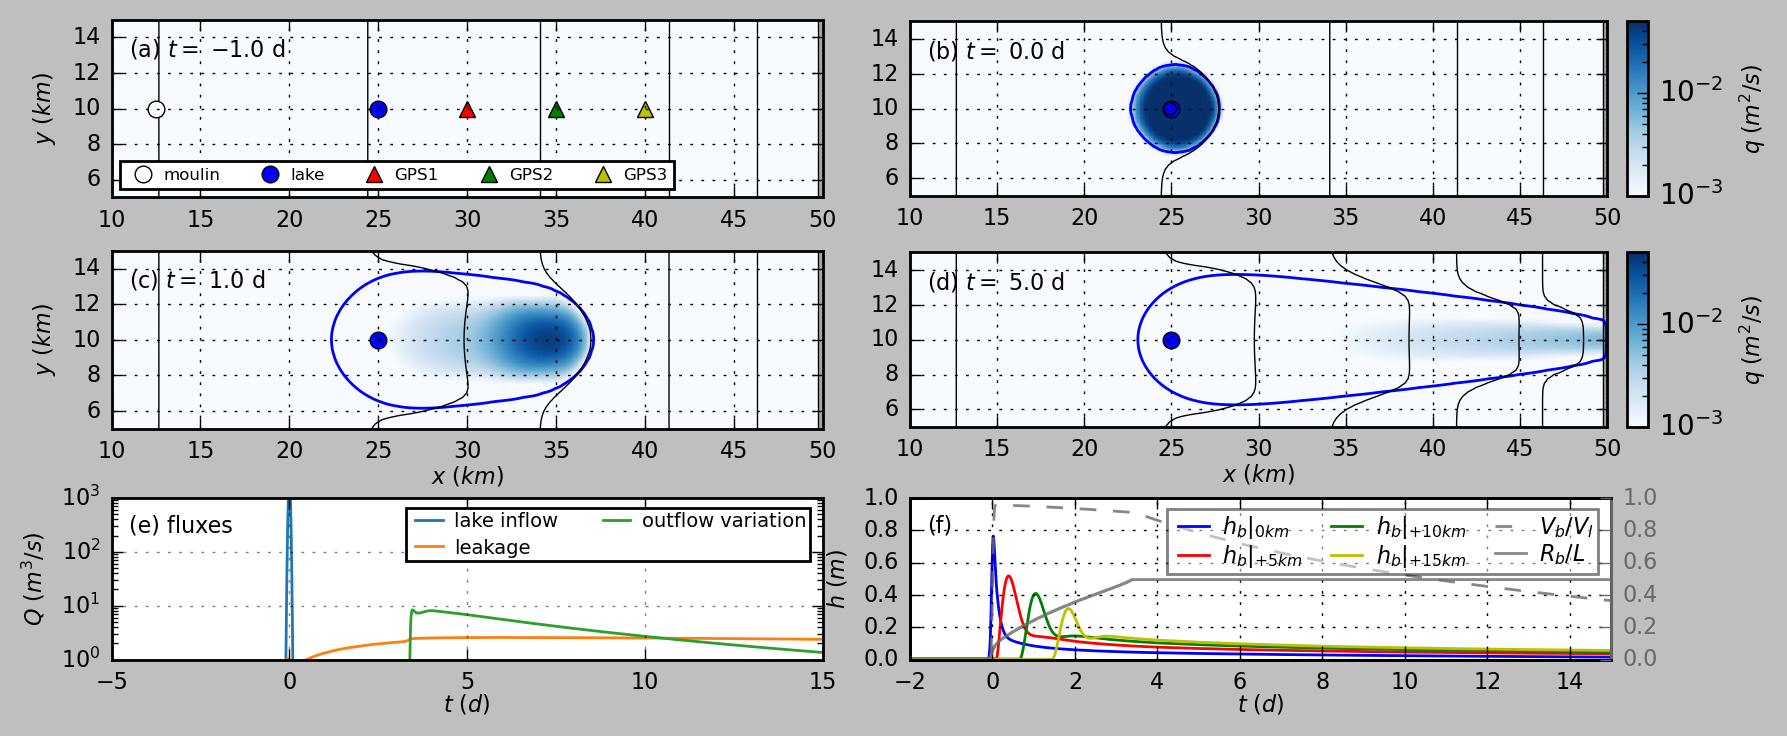

In [10]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

casename = 'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage'
# Flag to control data import
SKIP_DATA_IMPORT = False
LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data

# Check if key variables already exist
try:
    # Check if main data variables exist and are not empty
    if 'tt' in locals():
        if LOAD_NEW_DATA:
            print("Loading new data as requested...")
            SKIP_DATA_IMPORT = False
        elif tt is not None:
            print("Data already loaded, skipping import section...")
            SKIP_DATA_IMPORT = True
        else:
            print("Variables exist but are None, reloading data...")
            SKIP_DATA_IMPORT = False
    else:
        print("Variables not found, loading data...")
        SKIP_DATA_IMPORT = False
except NameError:
    print("Variables not defined, loading data...")
    SKIP_DATA_IMPORT = False

# -------------------- Parameters for plotting ---------------------------------------------
from cycler import cycler
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
             "#0072B2","#D55E00","#CC79A7","#000000"]
colors = okabe_ito
colors = plt.get_cmap('tab10').colors  

xa = 10 
xb = 50
ya = 5
yb = 15
plot_hb = False
plot_qs = True
h_min = 0  # min water thickness on the color bar (m)
h_max = 0.1  # max water thickness on the color bar (m)
q_min = 1e-3 # min water flux on the color bar (m^2/s)
q_max = 5e-2 # max water flux on the color bar (m^2/s)
# norm = PowerNorm(gamma=1, vmin=q_min, vmax=q_max)
norm = LogNorm(vmin=q_min, vmax=q_max)

tdrainge_d = 2.0 * 365 + 20
tmin  = tdrainge_d - 5
tmax  = tdrainge_d + 5
tmin_d = tmin 
tmax_d = tmax
tslice = tdrainge_d + np.array([-1, 0, 1, 5])

# Plotting setup
fontsize_panel = 8
fontsize_label = 8
fontsize_legend = 8

if (not SKIP_DATA_IMPORT) or (LOAD_NEW_DATA):
    print("Loading data...")
    # ------------------------- Import data -----------------------------------

    mat_path = os.path.join('results', casename, casename + '.mat')
    raw      = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    # 将关键参数转换为数值类型
    ps_t   = np.float64(ps['t'])
    pd_td  = np.float64(pd['td'])
    ps_hb  = np.float64(ps['hb'])
    ps_h   = np.float64(ps['h'])
    ps_x   = np.float64(ps['x'])
    ps_m   = np.float64(ps['m'])
    ps_S   = np.float64(ps['S'])
    ps_phi = np.float64(ps['phi'])
    ps_Q0  = np.float64(ps['Q0'])
    ps_Q   = np.float64(ps['Q'])
    ps_qs  = np.float64(ps['qs'])
    ps_qb  = np.float64(ps['qb'])

    pp_c8 = np.float64(pp['c8'])
    # 同样将 tt 中的数据转换为数值类型
    tt_t      = np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])

    # --- Compute time vectors -----------------------------------------------
    t = (ps_t / (24*60*60)) * tt_t        # days

    # --- Build derived quantities -------------------------------------------
    Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
    Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_Q = ps_Q  * tt_Q_outQ
    Q_out_q = ps_Q  * tt_Q_outq
    E       = ps_m * ps_x**2 * tt_E

    pts_ni = np.int64(oo['pts_ni'].item())
    phi_0 = ps_phi * np.float64(aa['phi_0'].item())
    pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
    pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
    pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
    pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
    pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])
    pts_hc_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hc']])
    pts_hs_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hs']])

    # gps elevations
    #     14 15 16 17    18   19
    #.    8  9  10 11    12   13
    #.    2  3  4   5     6   7
    #.  -1km 0 5km 10km 15km 20km
    pts_hb_gps1 = ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hb']])
    pts_hb_gps2 = ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hb']])
    pts_hb_gps3 = ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hb']])
    pts_hb_gps4 = ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hb']])

    pts_hc_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hc']])
    pts_hc_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hc']])
    pts_hc_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hc']])
    pts_hc_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hc']])

    pts_hs_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hs']])
    pts_hs_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hs']])
    pts_hs_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hs']])
    pts_hs_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hs']])

    N = ps_phi * np.float64(tt['N'])  # MPa
    pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
    pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    # 对空间变量进行转换
    xx = ps_x/1e3 * np.float64(gg['nx'].item())
    yy = ps_x/1e3 * np.float64(gg['ny'].item())
    nI = int(gg['nI'].item())
    nJ = int(gg['nJ'].item())
    eI = int(gg['eI'].item())
    eJ = int(gg['eJ'].item())
    cI = int(gg['cI'].item())
    cJ = int(gg['cJ'].item())

    nmeanx = gg['nmeanx'].item()
    nmeany = gg['nmeany'].item()
    nmeans = gg['nmeans'].item()
    nmeanr = gg['nmeanr'].item()
    ein = gg['ein'].item()
    fin = gg['fin'].item()
    cin = gg['cin'].item()
    Dx = np.float64(gg['Dx'].item())
    Dy = np.float64(gg['Dy'].item())
    Ds = np.float64(gg['Ds'].item())
    Dr = np.float64(gg['Dr'].item())

    # --- get spatial pattern at different times -----------------------------
    tspan = ps_t/pd_td*oo['t_span']
    nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

    # run matlab script to extend the field for times
    filenames = [os.path.join('results', casename, f"{num:04d}.mat") for num in nums]
    print(f"Processing files: {filenames}")
    # save the filenames to a text file
    # Save filenames and casename to a .mat file for MATLAB to load
    filenames_array = np.array(filenames, dtype=object)
    sio.savemat('extend_field.mat', {
        'filenames': filenames_array,
        'casename': casename
    })
    # Use MATLAB’s -batch option to run the script and auto‐exit when done
    import subprocess
    matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
    subprocess.run([
        matlab_path,
        "-nodisplay",
        "-nosplash",
        "-nodesktop",
        "-batch",
        "nevis_nodedischarge_python"
    ], check=True)

    vhb = []
    vphi1 = []
    vhs = []
    vhc = []
    vt = []
    vqs = []
    vqe = []
    vqQ = []
    vqb = []

    for i in range(len(nums)):
        con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
        raw_con = sio.loadmat(con_path, squeeze_me=True)
        vv = raw_con['vv']
        vv2 = raw_con['vv2']

        # geometry values
        phi1_val = np.float64(vv['phi'].item())
        hb_val   = np.float64(vv['hb'].item())
        hs_val   = np.float64(vv['hs'].item())
        pb_val   = np.float64(vv['pb'].item())

        Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
        Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
        Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
        Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

        vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
        vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
        vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
        vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
        vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
        vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
        vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
        vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
        vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
        vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))

        # flux values
        qs_val = np.float64(vv2['qs'].item())
        qe_val = np.float64(vv2['qe'].item())
        qQ_val = np.float64(vv2['qQ'].item())
        qb_val = np.float64(vv2['qb'].item())
        vqs.append(np.array(np.reshape(qs_val, (nI, nJ), order='F'), dtype=np.float64))
        vqe.append(np.array(np.reshape(qe_val, (nI, nJ), order='F'), dtype=np.float64))
        vqQ.append(np.array(np.reshape(qQ_val, (nI, nJ), order='F'), dtype=np.float64))
        vqb.append(np.array(np.reshape(qb_val, (nI, nJ), order='F'), dtype=np.float64))
    vt = np.array(vt, dtype=np.float64)-tdrainge_d

# ================= Plotting setup ======================================
fig = plt.figure(figsize=(10, 4), dpi=100)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.style.use('classic')
plt.rc('axes', prop_cycle=cycler('color', colors))
plt.rcParams["figure.dpi"] = 600
# plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0, 0])
from matplotlib.colors import LogNorm

cmap = plt.cm.Blues
if plot_hb:
    pc = ax1.pcolormesh(xx, yy,
                        ps_hb * vhb[0] + ps_h * vhs[0] + ps_h * vhc[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    # norm = LogNorm(vmin=q_min, vmax=q_max)
    pc = ax1.pcolormesh(xx, yy,
                        ps_qs * vqs[0] + ps_qb * vqb[0] + ps_qs * vqQ[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax1.contour(xx, yy, ps_hb * vhb[0], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax1.clabel(
#     contour_lines,
#     inline=True,
#     fontsize=6,
#     fmt='%1.2f',
#     inline_spacing=2,
#     manual=[(20, 5), (27, 12)],# 手动指定少量标签位置
# )
contour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[0], colors='k', linewidths=0.5, linestyles='-')
# ax1.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# plot the moulin location
ax1.plot(12.5, 10, 'wo', markersize=6, label='moulin')
ax1.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax1.plot(30.0, 10, 'r^', markersize=6, label='GPS1')
ax1.plot(35.0, 10, 'g^', markersize=6, label='GPS2')
ax1.plot(40.0, 10, 'y^', markersize=6, label='GPS3')
# ax1.plot(45.0, 10, 'yo', markersize=6, label='GPS4')

ax1.text(0.025, 0.9, '(a) $t=$ '+ f'${vt[0]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax1.legend(loc='lower left', fontsize=6, frameon=True, handletextpad=0.2, ncol=5, labelspacing=0.2, numpoints=1)
# ax1.legend(loc='upper left', fontsize=6, frameon=False, handletext

ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
# ax1.set_xlabel('$x~(km)$')
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal')
ax1.grid()

# ================= Panel (b): blister at time b ================
ax2 = fig.add_subplot(gs[0, 1])
cmap = plt.cm.Blues
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax2.pcolormesh(xx, yy,
                        ps_hb * vhb[1] + ps_h * vhs[1] + ps_h * vhc[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax2.pcolormesh(xx, yy,
                        ps_qs * vqs[1] + ps_qb * vqb[1] + ps_qs * vqQ[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

ax2.plot(25.0, 10, 'bo', markersize=6, label='lake')
cbar = fig.colorbar(pc, cax=cax2, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
contour_lines = ax2.contour(xx, yy, ps_hb * vhb[1], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax2.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='k', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax2.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax2.text(0.025, 0.9, '(b) $t=$ '+ f'${vt[1]:.1f}$ d', transform=ax2.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax2.set_xlim(xa, xb)
ax2.set_ylim(ya, yb)
# ax2.set_xlabel('$x~(km)$')
# ax2.set_ylabel('$y~(km)$')
ax2.set_aspect('equal')
ax2.grid()

# ================= Panel (c): blister at time c ================
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Blues
if plot_hb:
    pc = ax3.pcolormesh(xx, yy,
                        ps_hb * vhb[2] + ps_h * vhs[2] + ps_h * vhc[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax3.pcolormesh(xx, yy,
                        ps_qs * vqs[2] + ps_qb * vqb[2] + ps_qs * vqQ[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax3.contour(xx, yy, ps_hb * vhb[2], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax3.contour(xx, yy, ps_phi/1e6*vphi1[2], colors='k', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax3.plot(12.5, 10, 'wo', markersize=4, label='moulin')
ax3.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax3.text(0.025, 0.9, '(c) $t=$ '+ f'${vt[2]:.1f}$ d', transform=ax3.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax3.set_xlim(xa, xb)
ax3.set_ylim(ya, yb)
ax3.set_xlabel('$x~(km)$')
ax3.xaxis.set_label_coords(0.5, -0.2)
ax3.set_ylabel('$y~(km)$')
ax3.set_aspect('equal')
ax3.grid()

# ================= Panel (d): blister at time d ================
ax4 = fig.add_subplot(gs[1, 1])
cmap = plt.cm.Blues

divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax4.pcolormesh(xx, yy,
                        ps_hb * vhb[3] + ps_h * vhs[3] + ps_h * vhc[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax4.pcolormesh(xx, yy,
                        ps_qs * vqs[3] + ps_qb * vqb[3] + ps_qs * vqQ[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

pc.set_edgecolor('face')
cbar = fig.colorbar(pc, cax=cax4, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   

# Plot contour lines for the blister alone
contour_lines = ax4.contour(xx, yy, ps_hb * vhb[3], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax4.contour(xx, yy, ps_phi/1e6*vphi1[3], colors='k', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax4.plot(25.0, 10, 'bo', markersize=6, label='lake')

ax4.text(0.025, 0.9, '(d) $t=$ '+ f'${vt[3]:.1f}$ d', transform=ax4.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax4.set_xlim(xa, xb)
ax4.set_ylim(ya, yb)
ax4.set_xlabel('$x~(km)$')
# set x label position
ax4.xaxis.set_label_coords(0.5, -0.2)

# ax4.set_ylabel('$y~(km)$')
ax4.set_aspect('equal')
ax4.grid()

# ============== Panel (e): Flux (last row: spanning both columns) ==============
# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, 0])
ax5.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_left   = ax3.get_position()
pos_right  = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Compute full available width
full_width = pos_left.x1 - pos_left.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax5_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
ax5_pos = [ax5_x0, pos_bottom.y0, ax5_width, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax5_x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)

ax5.plot(t-tdrainge_d, Q_b_in, '-',    linewidth=1.0, label='lake inflow')
ax5.plot(t-tdrainge_d, Q_b_dec,'-',    linewidth=1.0, label='leakage')
ax5.plot(t-tdrainge_d, Q_out_b + Q_out_Q + Q_out_q - E, '-', linewidth=1.0, label=r'outflow variation')
# ax5.plot(t-tdrainge_d, E,       '-',    linewidth=1.0, label='moulin inflow')

# vertical lines for time points in (a), (b), (c), (d)
# labels = ['(a)', '(b)', '(c)', '(d)']
# for i,t_val in enumerate(vt):
#     ax5.axvline(t_val, ymin=1e-6, ymax=1e5, color='k', linestyle='--', linewidth=1.0, alpha=1.0, dashes=(2, 2))
#     ax5.text(t_val+0.2, 3e2, labels[i], ha='center', va='bottom', fontsize=6, color='k')

ax5.set_yscale('log')
ax5.set_xlim(tmin_d-tdrainge_d, tmax_d-tdrainge_d+10)
ax5.set_xlabel('$t~(d)$')
ax5.xaxis.set_label_coords(0.5, -0.2)
ax5.set_ylim(1e0, 1e3)
ax5.set_ylabel(r'$Q~(m^3/s)$')
ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
ax5.legend(loc='upper left',  bbox_to_anchor=(0.4, 1.0), frameon=True, fontsize=7, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax5.grid(alpha=0.5)

# ============== Panel (f): total volume and thickness ==============
ax6 = fig.add_subplot(gs[2, 1])
ax6.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_right  = ax4.get_position()
pos_bottom = gs[2, 1].get_position(fig)

# Compute full available width
full_width = pos_right.x1 - pos_right.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax6_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax6_x0 = pos_right.x0 + (full_width - ax6_width)/2
ax6_pos = [ax6_x0, pos_bottom.y0, ax6_width*0.95, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax6_x0 + ax6_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax6 = fig.add_axes(ax6_pos)
# ============== Plot thickness ==============
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_lake + ps_h*(pts_hc_gps1+pts_hs_gps1), 'b-', linewidth=1.0, label='$h_b|_{0km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps2 + ps_h*(pts_hc_gps2+pts_hs_gps2), 'r-', linewidth=1.0, label='$h_b|_{+5km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps3 + ps_h*(pts_hc_gps3+pts_hs_gps3), 'g-', linewidth=1.0, label='$h_b|_{+10km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps4 + ps_h*(pts_hc_gps4+pts_hs_gps4), 'y-', linewidth=1.0, label='$h_b|_{+15km}$', alpha=1.0)

ax6.set_xlim(tmin_d+3-tdrainge_d, tmax_d+10-tdrainge_d)
ax6.set_xlabel('$t~(d)$')
ax6.xaxis.set_label_coords(0.5, -0.2)
ax6.set_ylim(0, 1.0)
ax6.set_ylabel(r'$h~(m)$')
ax6.text(0.025, 0.9, '(f)', transform=ax6.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
# ax6.legend(loc='lower left',  bbox_to_anchor=(0.1, -0.7), frameon=True, fontsize=8, ncol=4,
#            labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax6.grid(alpha=1.0)

# ============== Plot volume ==============
ax6_twin = ax6.twinx()
ax6_twin.plot(t-tdrainge_d, V_b/1e7, '--', color='dimgray', linewidth=1.0, label='$V_b/V_l$', alpha=0.8)
ax6_twin.plot(t-tdrainge_d, R_b/5e4, '-', color='dimgray', linewidth=1.0, label='$R_b/L$', alpha=0.8)

ax6_twin.set_xlabel('$t~(d)$')
# ax6_twin.set_ylabel(r'$V_b/V_l$', fontsize=8)
ax6_twin.set_ylim(0, 1.0)
ax6_twin.tick_params(axis='y', labelsize=8)
ax6_twin.grid(alpha=0.0)
# make axis and label blue
ax6_twin.spines['right'].set_color('dimgray')
ax6_twin.yaxis.label.set_color('dimgray')
ax6_twin.tick_params(axis='y', colors='dimgray')

# combine legend entries from ax6 and its twin
handles1, labels1 = ax6.get_legend_handles_labels()
handles2, labels2 = ax6_twin.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left',
    bbox_to_anchor=(0.35, 1.00), fontsize=8, ncol=3,
    labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
    frameon=True, framealpha=0.5)

fig.savefig(
    './results/figures/Fig2_wintertime.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)
plt.show()

Loading new data as requested...
Loading data...
Processing files: ['results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0222.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0224.mat']


/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_13920/1623305558.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for colorbar


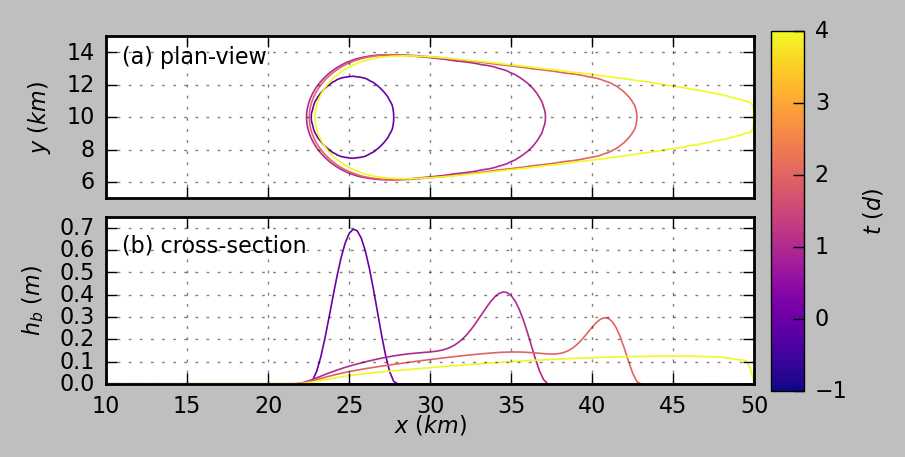

In [11]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Flag to control data import
SKIP_DATA_IMPORT = True
LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data
casename = 'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage'

# Check if key variables already exist
try:
    # Check if main data variables exist and are not empty
    if 'tt' in locals():
        if LOAD_NEW_DATA:
            print("Loading new data as requested...")
            SKIP_DATA_IMPORT = False
        elif tt is not None:
            print("Data already loaded, skipping import section...")
            SKIP_DATA_IMPORT = True
        else:
            print("Variables exist but are None, reloading data...")
            SKIP_DATA_IMPORT = False
    else:
        print("Variables not found, loading data...")
        SKIP_DATA_IMPORT = False
except NameError:
    print("Variables not defined, loading data...")
    SKIP_DATA_IMPORT = False

# -------------------- Parameters for plotting ---------------------------------------------
from cycler import cycler
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
             "#0072B2","#D55E00","#CC79A7","#000000"]
colors = okabe_ito
colors = plt.get_cmap('tab10').colors  

xa = 10 
xb = 50
ya = 5
yb = 15
plot_hb = False
plot_qs = True
h_min = 0  # min water thickness on the color bar (m)
h_max = 0.1  # max water thickness on the color bar (m)
q_min = 1e-3 # min water flux on the color bar (m^2/s)
q_max = 5e-2 # max water flux on the color bar (m^2/s)
# norm = PowerNorm(gamma=1, vmin=q_min, vmax=q_max)
norm = LogNorm(vmin=q_min, vmax=q_max)

tdrainge_d = 2.0 * 365 + 20
tmin  = tdrainge_d - 5
tmax  = tdrainge_d + 5
tmin_d = tmin 
tmax_d = tmax
tslice = tdrainge_d + np.array([-1, 0, 1, 2, 4])

if (not SKIP_DATA_IMPORT) or (LOAD_NEW_DATA):
    print("Loading data...")
    # ------------------------- Import data -----------------------------------

    mat_path = os.path.join('results', casename, casename + '.mat')
    raw      = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    # 将关键参数转换为数值类型
    ps_t   = np.float64(ps['t'])
    pd_td  = np.float64(pd['td'])
    ps_hb  = np.float64(ps['hb'])
    ps_h   = np.float64(ps['h'])
    ps_x   = np.float64(ps['x'])
    ps_m   = np.float64(ps['m'])
    ps_S   = np.float64(ps['S'])
    ps_phi = np.float64(ps['phi'])
    ps_Q0  = np.float64(ps['Q0'])
    ps_Q   = np.float64(ps['Q'])
    ps_qs  = np.float64(ps['qs'])
    ps_qb  = np.float64(ps['qb'])

    pp_c8 = np.float64(pp['c8'])
    # 同样将 tt 中的数据转换为数值类型
    tt_t      = np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])

    # --- Compute time vectors -----------------------------------------------
    t = (ps_t / (24*60*60)) * tt_t        # days

    # --- Build derived quantities -------------------------------------------
    Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
    Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_Q = ps_Q  * tt_Q_outQ
    Q_out_q = ps_Q  * tt_Q_outq
    E       = ps_m * ps_x**2 * tt_E

    pts_ni = np.int64(oo['pts_ni'].item())
    phi_0 = ps_phi * np.float64(aa['phi_0'].item())
    pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
    pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
    pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
    pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
    pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])
    pts_hc_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hc']])
    pts_hs_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hs']])


    pts_hb_gps1 = ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hb']])
    pts_hb_gps2 = ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hb']])
    pts_hb_gps3 = ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hb']])
    pts_hb_gps4 = ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hb']])

    pts_hc_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hc']])
    pts_hc_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hc']])
    pts_hc_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hc']])
    pts_hc_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hc']])

    pts_hs_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hs']])
    pts_hs_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hs']])
    pts_hs_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hs']])
    pts_hs_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hs']])

    N = ps_phi * np.float64(tt['N'])  # MPa
    pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
    pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    # 对空间变量进行转换
    xx = ps_x/1e3 * np.float64(gg['nx'].item())
    yy = ps_x/1e3 * np.float64(gg['ny'].item())
    nI = int(gg['nI'].item())
    nJ = int(gg['nJ'].item())
    eI = int(gg['eI'].item())
    eJ = int(gg['eJ'].item())
    cI = int(gg['cI'].item())
    cJ = int(gg['cJ'].item())

    nmeanx = gg['nmeanx'].item()
    nmeany = gg['nmeany'].item()
    nmeans = gg['nmeans'].item()
    nmeanr = gg['nmeanr'].item()
    ein = gg['ein'].item()
    fin = gg['fin'].item()
    cin = gg['cin'].item()
    Dx = np.float64(gg['Dx'].item())
    Dy = np.float64(gg['Dy'].item())
    Ds = np.float64(gg['Ds'].item())
    Dr = np.float64(gg['Dr'].item())

    # --- get spatial pattern at different times -----------------------------
    tspan = ps_t/pd_td*oo['t_span']
    nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

    # run matlab script to extend the field for times
    filenames = [os.path.join('results', casename, f"{num:04d}.mat") for num in nums]
    print(f"Processing files: {filenames}")
    # save the filenames to a text file
    # Save filenames and casename to a .mat file for MATLAB to load
    filenames_array = np.array(filenames, dtype=object)
    sio.savemat('extend_field.mat', {
        'filenames': filenames_array,
        'casename': casename
    })
    # Use MATLAB’s -batch option to run the script and auto‐exit when done
    import subprocess
    matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
    subprocess.run([
        matlab_path,
        "-nodisplay",
        "-nosplash",
        "-nodesktop",
        "-batch",
        "nevis_nodedischarge_python"
    ], check=True)

    vhb = []
    vphi1 = []
    vhs = []
    vhc = []
    vt = []
    vqs = []
    vqe = []
    vqQ = []
    vqb = []

    for i in range(len(nums)):
        con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
        raw_con = sio.loadmat(con_path, squeeze_me=True)
        vv = raw_con['vv']
        vv2 = raw_con['vv2']

        # geometry values
        phi1_val = np.float64(vv['phi'].item())
        hb_val   = np.float64(vv['hb'].item())
        hs_val   = np.float64(vv['hs'].item())
        pb_val   = np.float64(vv['pb'].item())

        Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
        Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
        Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
        Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

        vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
        vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
        vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
        vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
        vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
        vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
        vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
        vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
        vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
        vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))

        # flux values
        qs_val = np.float64(vv2['qs'].item())
        qe_val = np.float64(vv2['qe'].item())
        qQ_val = np.float64(vv2['qQ'].item())
        qb_val = np.float64(vv2['qb'].item())
        vqs.append(np.array(np.reshape(qs_val, (nI, nJ), order='F'), dtype=np.float64))
        vqe.append(np.array(np.reshape(qe_val, (nI, nJ), order='F'), dtype=np.float64))
        vqQ.append(np.array(np.reshape(qQ_val, (nI, nJ), order='F'), dtype=np.float64))
        vqb.append(np.array(np.reshape(qb_val, (nI, nJ), order='F'), dtype=np.float64))

    vt = np.array(vt, dtype=np.float64)-tdrainge_d

# ================= Plotting setup ======================================
fig = plt.figure(figsize=(4.5, 3), dpi=100)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], wspace=0.05, hspace=0.3)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
# ax3 = plt.subplot(gs[2, 0])
cax = plt.subplot(gs[:, 1])

pos1 = ax1.get_position()
pos2 = ax2.get_position()
# pos3 = ax3.get_position()
poscax = cax.get_position()

vertical_gap = -0.008
# Set ax2's bottom to be just below ax1's top
new_pos2_bottom = pos1.y0 - 0.8*pos2.height - vertical_gap
ax2.set_position([pos2.x0, new_pos2_bottom, pos2.width, 0.8*pos2.height])
# ax3.set_position([pos3.x0, pos3.y0 +0.07
#                   , pos3.width, pos3.height])
cax.set_position([poscax.x0, pos2.y0+0.17
                  , poscax.width, pos1.y0+ pos1.height - pos2.y0 - 0.2])

plt.style.use('classic')
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 7  # 坐标轴标签字体大小
plt.rcParams['xtick.labelsize'] = 7 # X轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 7 # Y轴刻度字体大小
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

import matplotlib.cm as cm
from matplotlib.lines import Line2D
cmap = plt.cm.plasma
norm = PowerNorm(gamma=1.0, vmin=np.min(vt), vmax=np.max(vt))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# ================= Panel (a): blister profile (plan view) =================
for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    CS = ax1.contour(xx, yy, ps_hb * vhb[i], levels=[0.01], colors=[color_i])

cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('$t~(d)$')

ax1.set_xlim(10, 50)
ax1.set_ylim(5, 15)
ax1.tick_params(axis='x', labelbottom=False)  # 隐藏x轴刻度标签
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal', adjustable='box')
ax1.text(0.025, 0.8, '(a) plan-view', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=8, clip_on=False)
ax1.grid(alpha=0.5)

# ================= Panel (b): blister profile (cross section) =================
p = []
for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    p.append(ax2.plot(xx[:,0], ps_hb * vhb[i][:,nJ//2], color=color_i))  # Plot each time step

ax2.set_xlabel('$x~(km)$')
ax2.xaxis.set_label_coords(0.5, -0.175)
ax2.set_ylabel('$h_b~(m)$')
ax2.set_xlim(10, 50)
ax2.set_ylim(0, 0.75)
ax2.text(0.025, 0.9, '(b) cross-section', transform=ax2.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax2.grid(alpha=0.5)

# # ================= Panel (c): Time series of discharge =================
# ax3.plot(t-tdrainge_d, R_b/5e4, color='k', label='$R/L$')
# ax3.plot(t-tdrainge_d, V_b/1e7, color='b', label='$V/V_l$')

# ax3.set_xlabel('$t(d)$',fontsize=8)
# ax3.set_xlim(tmin_d+2-tdrainge_d, tmax_d+2-tdrainge_d)
# ax3.set_ylim(0, 1)
# legend = ax3.legend(loc='lower left', fontsize='small')
# legend.get_frame().set_linewidth(0.5)  # Adjust the linewidth of the legend box
# ax3.text(0.025, 0.9, '(c) time series', transform=ax3.transAxes,
#          ha='left', va='top', fontsize=8, clip_on=False, color='black')
# ax3.grid(alpha=0.5)

# # Add vertical lines for each time slice
# for i in range(len(vt)):
#     ax3.axvline(x=vt[i], color=cmap(norm(vt[i])), linewidth=0.8, linestyle='--', dashes=(2, 2))

fig.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for colorbar

fig.savefig(
    'Fig4_cross_section.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()


749.942 749.9777000000001 22500.0 2500.0 2249.9999999999964 6.484075111501841 (1089,)
749.952 750.0018000000002 22500.0 2500.0 2249.9999999999964 4.6482225196868 (1196,)
749.9630000000001 750.0505 22500.0 2500.0 2249.9999999999964 2.645502645503333 (1332,)
749.975 750.2970000000066 22500.0 2500.0 2249.9999999999964 0.7188865884370785 (1049,)
749.989 752.9600000000046 22500.0 2500.0 2249.9999999999964 0.07791365919930221 (1091,)
749.9290000000001 750.007 1000.0000000000009 249.99999999999912 0.0 0.11128917378937259 (752,)
749.966 752.1000000000001 4000.0000000000036 1000.0000000000009 749.999999999993 0.01627095699260551 (802,)
749.989 751.0400000000002 12500.0 2500.0 2249.9999999999964 0.1101243965182905 (1091,)
749.957 750.0386000000002 12500.0 2500.0 2249.9999999999964 1.4183914306427219 (1402,)


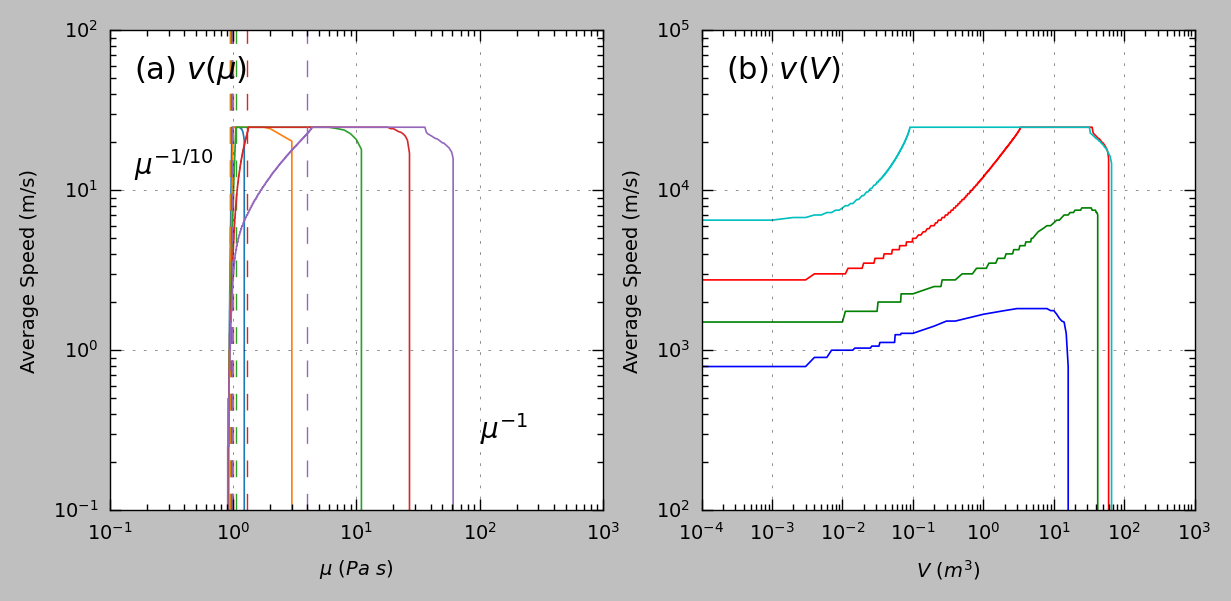

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import scipy.io as sio

fontsize_panel = 8

casenames = ['n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_13_mu1e_2_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_11_mu1e0_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage']

fig,ax = plt.subplots(1,2,figsize=(7, 3), dpi=100)
plt.style.use('classic')
plt.rcParams["figure.dpi"] = 600
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 7  # 坐标轴标签字体大小
plt.rcParams['xtick.labelsize'] = 7 # X轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 7 # Y轴刻度字体大小
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

vmu = np.array([1e-3,1e-2,1e-1, 1e0, 1e1])
# vmu = np.array([1e-2,1e-1, 1e1, 1e2, 1e3])
t_start = []
t_end = []
avg_speed1 = []
avg_speed2 = []
ax = plt.subplot(121)
for i,casename in enumerate(casenames):
    mat_path = os.path.join('results', casename, casename + '.mat')
    raw = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    ps_hb = np.float64(ps['hb'])
    ps_x = np.float64(ps['x'])
    ps_S = np.float64(ps['S'])
    ps_h = np.float64(ps['h'])
    ps_t = np.float64(ps['t'])
    
    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    t = (ps_t / (24*60*60)) * np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])    

    # find the max
    R_max = np.max(R_b)
    idx_start = np.where(R_b > 0.1*R_max)[0][0]
    idx_end = np.where(R_b > 0.9*R_max)[0][0]
    # average propagation speed of the front
    avg_speed1.append(1/(24*3600)*np.mean((R_b[idx_end]-R_b[idx_start]) / (t[idx_end] - t[idx_start])))
    print(t[idx_start], t[idx_end], R_b[idx_end], R_b[idx_start],R_b[idx_start-1], avg_speed1[-1], np.shape(t))
    ax.plot(t-tdrainge_d+1, R_b/1e3, color=colors[i])
    ax.axvline(x=t[idx_start]-tdrainge_d+1, color=colors[i], linestyle='--', linewidth=0.5)
    ax.axvline(x=t[idx_end]-tdrainge_d+1, color=colors[i], linestyle='--', linewidth=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')

avg_speed1 = np.array(avg_speed1)
# ax.plot(vmu, avg_speed1, marker='o', linestyle='-', color='b')
# ax.plot(vmu, 5e-1*vmu**(-1/10), linestyle='--', color='gray', label=r'$\mu^{-1/9}$') 
# ax.plot(vmu, vmu**(-1), linestyle='--', color='gray', label=r'$\mu^{-1}$')
ax.text(0.05,0.70, r'$\mu^{-1/10}$', fontsize=10, color='black', transform=ax.transAxes)
ax.text(0.75,0.15, r'$\mu^{-1}$', fontsize=10, color='black', transform=ax.transAxes)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\mu~(Pa~s)$')
ax.set_ylabel('Average Speed (m/s)')
ax.text(0.05, 0.9, r'(a) $v\left(\mu\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)

# ================= Panel (b): speed vs volume =================
vVl = np.array([1e5, 1e6, 1e7, 1e8])
# casenames = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e6_drainage',\
#              'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
#              'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e8_drainage']

casenames = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e5_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e8_drainage']
avg_speed2 = []
ax = plt.subplot(122)
for i,casename in enumerate(casenames):
    mat_path = os.path.join('results', casename, casename + '.mat')
    raw = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    ps_hb = np.float64(ps['hb'])
    ps_x = np.float64(ps['x'])
    ps_S = np.float64(ps['S'])
    ps_h = np.float64(ps['h'])
    ps_t = np.float64(ps['t'])

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])
    # smooth the R_b curve using scipy's savgol_filter
    from scipy.signal import savgol_filter
    n = 91  # window length, must be odd
    if n > len(R_b):
        n = len(R_b)
    if n % 2 == 0:  # ensure n is odd
        n += 1
    R_b_smooth = savgol_filter(R_b, n, 9)  # apply Sav

    t = (ps_t / (24*60*60)) * np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])    
    dRb_dt = np.gradient(R_b, t*(24*60*60))  # velocity in m/s

    # find the max
    R_max = np.max(R_b)
    idx_start = np.where(R_b > 0.1*R_max)[0][0]
    # idx_start = np.where(t > 750+0.025*5)[0][0]
    idx_end = np.where(R_b > 0.5*R_max)[0][0]
    # average propagation speed of the front
    avg_speed2.append(1/(24*3600)*np.mean((R_b[idx_end]-R_b[idx_start]) / (t[idx_end] - t[idx_start])))
    print(t[idx_start], t[idx_end], R_b[idx_end], R_b[idx_start],R_b[idx_start-1], avg_speed2[-1], np.shape(t))
    # ax.plot(t-tdrainge_d, dRb_dt, label=f'$V={vVl[i]}~m^3$')
    ax.plot(t-tdrainge_d, R_b, label=f'$V={vVl[i]}~m^3$')
    # if i < 2:
    #     ax.plot(V_b, R_b, marker='o', label=f'$V={vVl[i]}~m^3$')
    #     print(V_b, R_b_smooth)
    # else:
    #     ax.plot(V_b, R_b_smooth, label=f'$V={vVl[i]}~m^3$')
    # ax.axvline(x=t[idx_start]-tdrainge_d, color='gray', linestyle='--', linewidth=0.5)
    # ax.axvline(x=t[idx_end]-tdrainge_d, color='gray', linestyle='-', linewidth=0.5)

# ax.axvline(0+0.15, color='gray', linestyle='--', linewidth=0.5)
avg_speed2 = np.array(avg_speed2)
# ax.plot(vVl, avg_speed2, marker='o', linestyle='-', color='b')
# ax.plot(vVl, 1e-3*vVl**(3/13), linestyle='--', color='gray', label=r'$\mu^{-1/9}$')
# ax.plot(vVl, 1e-3*vVl**(3/8), linestyle='--', color='gray', label=r'$\mu^{-1}$')
# ax.plot(vVl, 1e-9*vVl**(1.2), linestyle='--', color='gray', label=r'$\mu^{-1}$')
# ax.legend(loc='lower left', fontsize='small')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$V~(m^3)$')
ax.set_ylabel('Average Speed (m/s)')
# ax.set_xlim(0, 1e3)
ax.set_ylim(1e2, 1e5)
ax.text(0.05, 0.9, r'(b) $v\left(V\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)

# fig.savefig(
#     'Fig5_velocity_2.png',
#     dpi=600,
#     transparent=False,
#     bbox_inches='tight',
#     pad_inches=0
# )

plt.show()

Processing: n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e7_drainage, Average Speed: 5.9748 m/s
Processing: n2d_0m3s_kappa1e_13_mu1e_2_hbreg5e_3_V1e7_drainage, Average Speed: 4.3003 m/s
Processing: n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e7_drainage, Average Speed: 2.5068 m/s
Processing: n2d_0m3s_kappa1e_11_mu1e0_hbreg5e_3_V1e7_drainage, Average Speed: 0.7419 m/s
Processing: n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage, Average Speed: 0.0830 m/s
Processing: n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e6_drainage, Average Speed: 3.3534 m/s
Processing: n2d_0m3s_kappa1e_13_mu1e_2_hbreg5e_3_V1e6_drainage, Average Speed: 1.2503 m/s
Processing: n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e6_drainage, Average Speed: 0.1648 m/s
Processing: n2d_0m3s_kappa1e_11_mu1e0_hbreg5e_3_V1e6_drainage, Average Speed: 0.0233 m/s
Processing: n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e6_drainage, Average Speed: 0.0061 m/s
Processing: n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e8_drainage, Average Speed: 8.0058 m/s
Processing: n2

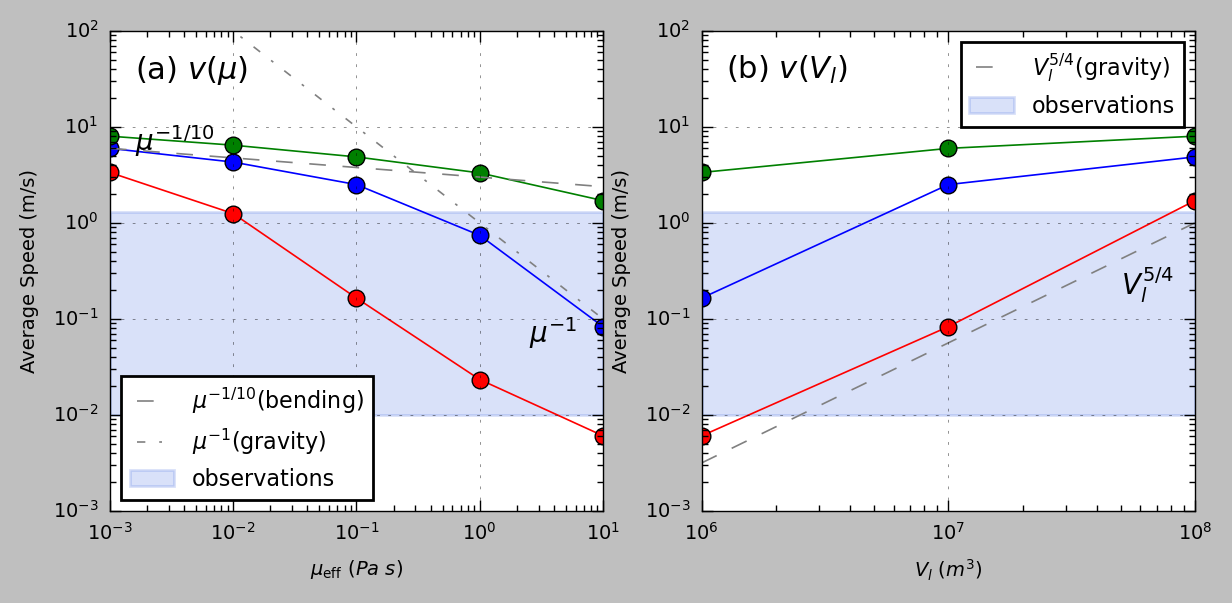

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import scipy.io as sio

class NevisCaseAnalyzer:
    """
    A class for loading and analyzing NEVIS .mat result files.

    This class can process one or more casenames, calculate the front propagation speed
    for each case, and store the results for later use.
    """
    def __init__(self, results_dir='results'):
        """
        Initialize the analyzer.

        Args:
            results_dir (str): Root directory containing casename result folders.
        """
        self.results_dir = results_dir
        self.results = {}

    def _load_and_process_case(self, casename):
        """
        Load and process data for a single case.
        """
        mat_path = os.path.join(self.results_dir, casename, f"{casename}.mat")
        try:
            raw = sio.loadmat(mat_path, squeeze_me=True)
        except FileNotFoundError:
            print(f"Warning: File not found {mat_path}, skipping this case.")
            return None

        # Extract data
        tt = raw['tt']
        ps = raw['ps']
        
        # Type conversion
        ps_x = np.float64(ps['x'])
        ps_t = np.float64(ps['t'])
        
        # Calculate derived quantities
        R_b = ps_x * np.float64(tt['Rb'])
        t = (ps_t / (24 * 60 * 60)) * np.float64(tt['t'])

        # Core analysis logic
        R_b = np.where(R_b > 25e3, 0.0, R_b)  # Filter outliers
        if not np.any(R_b > 0):
            print(f"Warning: In {casename}, R_b has no positive values, unable to calculate speed.")
            return None
            
        R_max = np.max(R_b)
        
        # Find start and end indices
        # start_indices = np.where(t > tdrainge_d)[0]
        start_indices = np.where((R_b > 0.1 * R_max) & (R_b < 0.5 * R_max))[0]
        end_indices = np.where((R_b > 0.8 * R_max) & (R_b < R_max))[0]

        if len(start_indices) == 0 or len(end_indices) == 0:
            print(f"Warning: Unable to determine start or end points in {casename}.")
            return None
            
        idx_start = start_indices[0]
        idx_end = end_indices[0]

        # Calculate average speed
        delta_R = R_b[idx_end] - R_b[idx_start]
        delta_t = t[idx_end] - t[idx_start]
        
        if delta_t == 0:
            print(f"Warning: Time difference is zero in {casename}, unable to calculate speed.")
            return None

        avg_speed = (delta_R / delta_t) / (24 * 3600)  # m/s
        # if avg_speed < 1e-2:
        #     avg_speed = np.nan  # Set to NaN if speed is too low
        print(f"Processing: {casename}, Average Speed: {avg_speed:.4f} m/s")
        return avg_speed

    def run_analysis(self, casenames):
        """
        Run analysis for a list of casenames.

        Args:
            casenames (list): List of casename strings to analyze.
        
        Returns:
            list: List of calculated average speeds.
        """
        avg_speeds = []
        for casename in casenames:
            speed = self._load_and_process_case(casename)
            if speed is not None:
                avg_speeds.append(speed)
        
        # Store results in the instance
        self.results['avg_speeds'] = avg_speeds
        return np.array(avg_speeds)


fontsize_panel = 8

casenames = ['n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_13_mu1e_2_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_11_mu1e0_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage']

casenames2 = ['n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_13_mu1e_2_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_11_mu1e0_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e6_drainage']

casenames3 = ['n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_13_mu1e_2_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_11_mu1e0_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e8_drainage']

fig,ax = plt.subplots(1,2,figsize=(7, 3), dpi=100)
plt.style.use('classic')
plt.rcParams["figure.dpi"] = 600
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 7  # 坐标轴标签字体大小
plt.rcParams['xtick.labelsize'] = 7 # X轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 7 # Y轴刻度字体大小
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# vmu = np.array([1e-4, 1e-3,1e-2,1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
vmu = np.array([1e-3,1e-2,1e-1, 1e0, 1e1])
# vmu = np.array([1e3])
t_start = []
t_end = []

ax = plt.subplot(121)
analyzer = NevisCaseAnalyzer()
avg_speed1 = analyzer.run_analysis(casenames)
avg_speed2 = analyzer.run_analysis(casenames2)
avg_speed3 = analyzer.run_analysis(casenames3)

ax.plot(vmu, avg_speed1, marker='o', linestyle='-', color='b')
ax.plot(vmu, avg_speed2, marker='o', linestyle='-', color='r')
ax.plot(vmu, avg_speed3, marker='o', linestyle='-', color='g')
ax.plot(vmu, 3e0*vmu**(-1/10), linestyle='--', color='gray', label=r'$\mu^{-1/10}$(bending)') 
ax.plot(vmu, vmu**(-1), linestyle='-.', color='gray', label=r'$\mu^{-1}$(gravity)')
ax.axhspan(0.01, 1.3, color='royalblue', alpha=0.2, label='observations')
ax.text(0.05,0.75, r'$\mu^{-1/10}$', fontsize=10, color='black', transform=ax.transAxes)
ax.text(0.85,0.35, r'$\mu^{-1}$', fontsize=10, color='black', transform=ax.transAxes)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\mu_{\text{eff}}~(Pa~s)$')
ax.set_ylabel('Average Speed (m/s)')
ax.set_ylim(1e-3, 1e2)
ax.text(0.05, 0.9, r'(a) $v\left(\mu\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)
ax.legend(loc='lower left', fontsize=8)

# ================= Panel (b): speed vs volume =================
ax = plt.subplot(122)
vVl = np.array([1e6, 1e7, 1e8])
# casenames = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e6_drainage',\
#              'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
#              'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e8_drainage']

casenames = ['n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e_1_hbreg5e_3_V1e8_drainage']

casenames2 = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e8_drainage']

casenames3 = ['n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_14_mu1e_3_hbreg5e_3_V1e8_drainage']

avg_speed1 = analyzer.run_analysis(casenames)
avg_speed2 = analyzer.run_analysis(casenames2)
avg_speed3 = analyzer.run_analysis(casenames3)

ax.plot(vVl, avg_speed1, marker='o', linestyle='-', color='b')
ax.plot(vVl, avg_speed2, marker='o', linestyle='-', color='r')
ax.plot(vVl, avg_speed3, marker='o', linestyle='-', color='g')

ax.plot(vVl, 1e-10*vVl**(5/4), linestyle='--', color='gray', label=r'$V_l^{5/4}$(gravity)')
ax.axhspan(0.01, 1.3, color='royalblue', alpha=0.2, label='observations')
ax.text(0.85,0.45, r'$V_l^{5/4}$', fontsize=10, color='black', transform=ax.transAxes)
# ax.plot(vVl, 1e-3*vVl**(3/8), linestyle='--', color='gray', label=r'$\mu^{-1}$')
# ax.plot(vVl, 1e-9*vVl**(1.2), linestyle='--', color='gray', label=r'$\mu^{-1}$')
# ax.legend(loc='lower left', fontsize='small')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$V_l~(m^3)$')
ax.set_ylabel('Average Speed (m/s)')
ax.set_xlim(1e6, 1e8)
ax.set_ylim(1e-3, 1e2)
ax.text(0.05, 0.9, r'(b) $v\left(V_l\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)
ax.legend(loc='upper right', fontsize=8)

# fig.savefig(
#     'Fig5_velocity_2.png',
#     dpi=600,
#     transparent=False,
#     bbox_inches='tight',
#     pad_inches=0
# )

plt.show()

9921062.99121698 2610.076627227637 750.098 (776,)
9971433.28623175 2761.3402542968097 750.1100000000001 (775,)
9982335.770801928 2795.0849718747318 750.1200000000001 (779,)
9984631.041156104 2795.0849718747318 750.1300000000002 (776,)


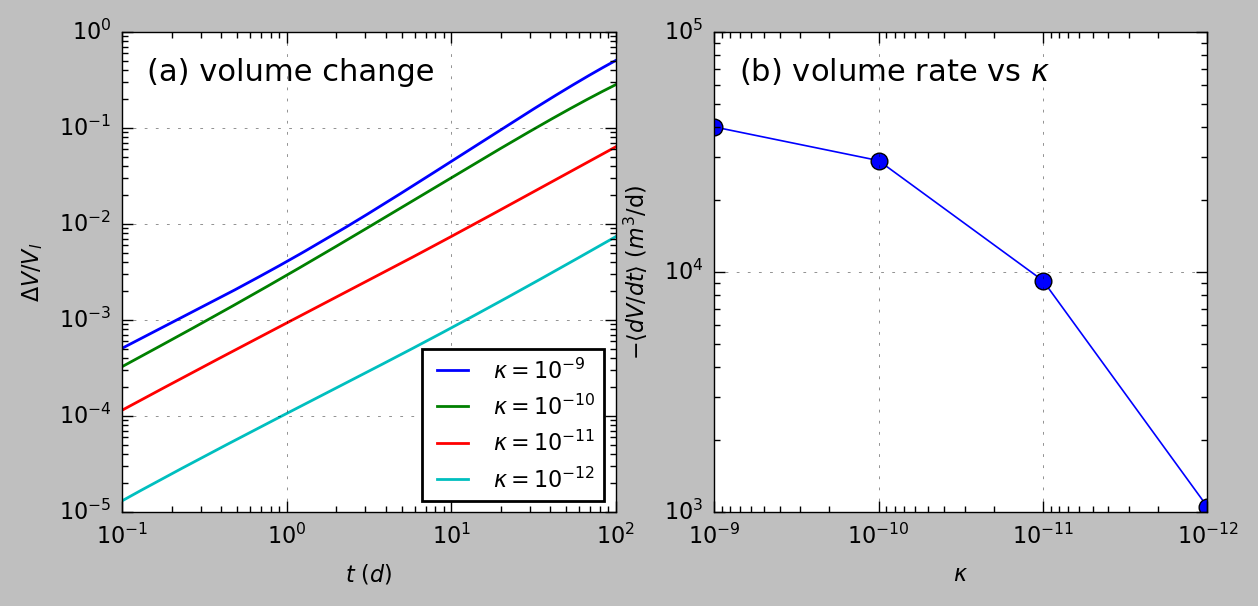

In [202]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

casenames = ['n2d_0m3s_kappa1e_9_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_11_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e3_hbreg5e_3_V1e7_drainage']

fig, ax = plt.subplots(1,2,figsize=(7, 3), dpi=100)
ax = plt.subplot(121)
vkappa = np.array([1e-9, 1e-10, 1e-11, 1e-12])

t_start = []
t_end = []
avg_dVdt = []
for i,casename in enumerate(casenames):
    mat_path = os.path.join('results', casename, casename + '.mat')
    raw = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    ps_hb = np.float64(ps['hb'])
    ps_x = np.float64(ps['x'])
    ps_S = np.float64(ps['S'])
    ps_h = np.float64(ps['h'])

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    dVdt = np.gradient(V_b, ps_t*(24*60*60))  # velocity in m/s
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    t = (ps_t / (24*60*60)) * np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])    

    idx_start = np.where((V_b > 0.9 * np.max(V_b)) & (dVdt < 0))[0][0]
    idx_end = np.where(t>t[idx_start]+1)[0][0]
    Vb0 = V_b[idx_start]
    Vbend = V_b[idx_end]
    avg_dVdt.append((Vbend - Vb0) / (t[idx_end] - t[idx_start]))
    exp = int(np.log10(vkappa[i])) 
    ax.plot(t-t[idx_start], 1-V_b/Vb0, linewidth=1.0, label=rf'$\kappa=10^{{{exp}}}$')
    # ax.plot(t-t[idx], R_b/25e3, linestyle='--')
    print(V_b[idx_start], R_b[idx_start], t[idx_start], np.shape(t))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-1, 100)
ax.set_ylim(1e-5, 1)
ax.set_xlabel(r'$t~(d)$',fontsize = fontsize_panel)
ax.set_ylabel(r'$\Delta V/V_l$',fontsize = fontsize_panel)
ax.tick_params(axis='both', labelsize=fontsize_panel) 
ax.text(0.05, 0.9, r'(a) volume change', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.legend(loc='lower right', fontsize=fontsize_legend)
ax.grid(alpha=0.5)

# # ================= Panel (b): speed vs volume =================
ax = plt.subplot(122)
avg_dVdt = np.array(avg_dVdt)
ax.plot(vkappa, -avg_dVdt, marker='o', linestyle='-', color='b')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-9, 1e-12)
ax.set_xlabel(r'$\kappa$',fontsize = fontsize_panel)
ax.set_ylabel(r'$-\langle {dV/dt} \rangle$ ($m^3$/d)',fontsize = fontsize_panel)
ax.tick_params(axis='both', labelsize=fontsize_panel) 
ax.text(0.05, 0.9, r'(b) volume rate vs $\kappa$', fontsize = fontsize_panel+3, transform=ax.transAxes)
# ax.legend(loc='lower right', fontsize=fontsize_legend)
ax.grid(alpha=0.5)

fig.savefig(
    'Fig6_volume.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()